# Corpus analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import json
import re
from tqdm import tqdm

## Load data

In [2]:
# labels
with open("labels.json") as f:
    LABELS = json.load(f)

# sentences
df = pd.read_csv("sentences.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns = ["Unnamed: 0"])
print(df.shape)

# convert strings back to lists using json.loads
df["label_anno"] = df["label_anno"].apply(lambda x: json.loads(x.replace("'", '"')))
df["label_pred"] = df["label_pred"].apply(lambda x: json.loads(x.replace("'", '"')))
df["aspect_certainty"] = df["aspect_certainty"].astype(str)
df["aspect_certainty"] = df["aspect_certainty"].apply(lambda x: json.loads(x.replace("'", '"')))
df["unique_label"] = df["label_pred"].apply(lambda x: x[0] if len(x) == 1 else "mixed")

/tmp/ipykernel_47106/1687292015.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sentences.csv")


(15850809, 20)


In [3]:
df.head()

sentence_id  paper_id  sent_id_in_paper  \
0            0         0                 0   
1            1         0                 1   
2            2         0                 2   
3            3         0                 3   
4            4         0                 4   

                                            sentence   section  -2  -1  \
0  There is a need to measure word similarity whe...  abstract  -1  -1   
1  Usually, measures of similarity between two wo...  abstract  -1   0   
2  The taxonomy approaches are more or less seman...  abstract   0   1   
3  However, in real applications, both semantic a...  abstract   1   2   
4  Word similarity based on context vectors is a ...  abstract   2   3   

   candidate  sentence_certainty  \
0       True            4.546492   
1       True            4.729261   
2       True            4.835920   
3       True            4.872213   
4       True            4.952981   

                                    aspect_certainty label_anno  \
0  [[Condition, Certain], [Suggestion, Certain], ...         []   
1      [[Extent, Uncertain], [Probability, Certain]]         []   
2                           [[Probability, Certain]]         []   
3    [[Probability, Certain], [Suggestion, Certain]]         []   
4                           [[Probability, Certain]]         []   

      label_pred  rel_pos_in_paper unique_label  Number     Extent  \
0  [context-AIC]          0.005291  context-AIC  absent     absent   
1  [context-AIC]          0.010582  context-AIC  absent  Uncertain   
2  [context-AIC]          0.015873  context-AIC  absent     absent   
3  [context-AIC]          0.021164  context-AIC  absent     absent   
4  [context-AIC]          0.026455  context-AIC  absent     absent   

  Probability Condition  Framing Suggestion  
0      absent   Certain  Certain    Certain  
1     Certain    absent   absent     absent  
2     Certain    absent   absent     absent  
3     Certain    absent   absent    Certain  
4     Certain    absent   absent     absent

## Distribution of labels

### On inferred predictions

In [70]:
counts = {i+1:[] for i in range(len(LABELS))}

for label in LABELS:
    occurrences = df[df["label_pred"].apply(lambda x: label in x)].label_pred.values.tolist()
    for i in range(len(LABELS)):
        occ_i = [occ for occ in occurrences if len(occ) == i+1]
        counts[i+1].append(len(occ_i))

In [71]:
df_counts = pd.DataFrame(counts, index = LABELS)
df_counts

1       2     3   4  5  6  7  8
context-AIC        1412003   27860   410   2  0  0  0  0
contribution-AIC    989483  116667  1454  11  0  0  0  0
result             2329273  197370  3555  92  0  0  0  0
impact               62426   47464  2322  93  0  0  0  0
directions          225839   33244  2348  81  0  0  0  0
limitation          148854  122275  2397  88  0  0  0  0
outline-AIC         122040   19842   720   5  0  0  0  0
nc                10258678       0     0   0  0  0  0  0

In [72]:
totals = []
for label in LABELS:
    t = sum([df_counts.at[label, i+1] for i in range(len(LABELS))])
    totals.append(t)

df_counts["total"] = totals
df_counts

1       2     3   4  5  6  7  8     total
context-AIC        1412003   27860   410   2  0  0  0  0   1440275
contribution-AIC    989483  116667  1454  11  0  0  0  0   1107615
result             2329273  197370  3555  92  0  0  0  0   2530290
impact               62426   47464  2322  93  0  0  0  0    112305
directions          225839   33244  2348  81  0  0  0  0    261512
limitation          148854  122275  2397  88  0  0  0  0    273614
outline-AIC         122040   19842   720   5  0  0  0  0    142607
nc                10258678       0     0   0  0  0  0  0  10258678

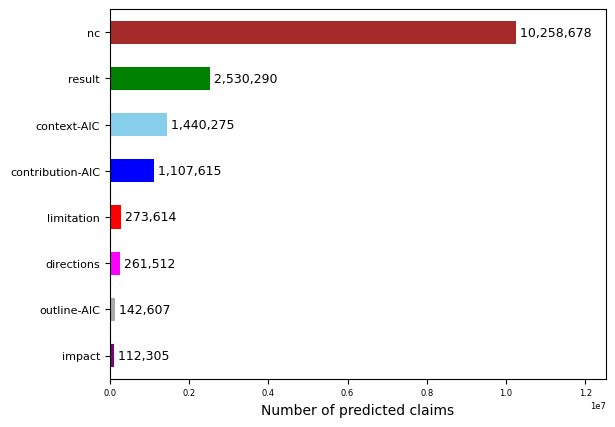

In [73]:
colors = {"nc": "brown",
          "result": "green",
          "context-AIC": "skyblue",
          "contribution-AIC": "blue",
          "limitation": "red",
          "directions": "magenta",
          "outline-AIC": "darkgrey",
          "impact": "purple",
         }

df_counts = df_counts.sort_values(by = "total")
palette = [colors[label] for label in df_counts.index]
ax = df_counts["total"].plot(kind = "barh", color = palette)
# plt.set_yticks([i for i in range(10)])

for i, label in enumerate(df_counts.index):
    count = df_counts.at[label, "total"]
    count_s =  "{:,}".format(int(count))
    plt.text(count, i, f" {count_s}", va = "center", fontsize = 9)
ax.set_xlim(0, df_counts["total"].max() * 1.22)
plt.xlabel("Number of predicted claims")
#plt.ylabel("Claim category")
plt.savefig("../results/pred-claims-distribution-inf.png", dpi = 300, bbox_inches= "tight")
plt.show()

In [74]:
df_counts_norm = df_counts.copy()
for col in df_counts_norm.columns:
    df_counts_norm[col] = df_counts_norm[col] / df_counts_norm["total"]

df_counts_norm

1         2         3         4    5    6    7    8  \
impact            0.555861  0.422635  0.020676  0.000828  0.0  0.0  0.0  0.0   
outline-AIC       0.855778  0.139138  0.005049  0.000035  0.0  0.0  0.0  0.0   
directions        0.863589  0.127122  0.008979  0.000310  0.0  0.0  0.0  0.0   
limitation        0.544029  0.446889  0.008761  0.000322  0.0  0.0  0.0  0.0   
contribution-AIC  0.893346  0.105332  0.001313  0.000010  0.0  0.0  0.0  0.0   
context-AIC       0.980370  0.019344  0.000285  0.000001  0.0  0.0  0.0  0.0   
result            0.920556  0.078003  0.001405  0.000036  0.0  0.0  0.0  0.0   
nc                1.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0   

                  total  
impact              1.0  
outline-AIC         1.0  
directions          1.0  
limitation          1.0  
contribution-AIC    1.0  
context-AIC         1.0  
result              1.0  
nc                  1.0

In [121]:
df_acl = df[df["source"] == "ACL"]
df_arx = df[df["source"] == "arXiv"]
print(df_acl.shape, df_arx.shape)

(9339173, 21) (6511636, 21)


In [124]:
dfs = [df_acl, df_arx]
df_counts_list = []
df_norms_list = []

for df_ in dfs:
    counts = {i+1:[] for i in range(len(LABELS))}
    
    for label in LABELS:
        occurrences = df_[df_["label_pred"].apply(lambda x: label in x)].label_pred.values.tolist()
        for i in range(len(LABELS)):
            occ_i = [occ for occ in occurrences if len(occ) == i+1]
            counts[i+1].append(len(occ_i))
    
    df_counts_ = pd.DataFrame(counts, index = LABELS)

    totals = []
    for label in LABELS:
        t = sum([df_counts_.at[label, i+1] for i in range(len(LABELS))])
        totals.append(t)
    
    df_counts_["total"] = totals
    df_counts_list.append(df_counts_)

    df_counts_norm_ = df_counts_.copy()
    for col in df_counts_norm.columns:
        df_counts_norm_[col] = df_counts_norm_[col] / df_counts_norm_["total"]

    df_norms_list.append(df_counts_norm_)

In [189]:
df_counts_list[0]

1       2     3   4  5  6  7  8    total
context-AIC        832928   17280   234   2  0  0  0  0   850444
contribution-AIC   603921   67486   771   7  0  0  0  0   672185
result            1361590  117279  2008  50  0  0  0  0  1480927
impact              33397   25186  1109  51  0  0  0  0    59743
directions         147771   19485  1424  43  0  0  0  0   168723
limitation          72902   75148  1370  48  0  0  0  0   149468
outline-AIC         85442   12942   434   3  0  0  0  0    98821
nc                6024254       0     0   0  0  0  0  0  6024254

In [190]:
df_counts_list[1]

1      2     3   4  5  6  7  8    total
context-AIC        579075  10580   176   0  0  0  0  0   589831
contribution-AIC   385562  49181   683   4  0  0  0  0   435430
result             967683  80091  1547  42  0  0  0  0  1049363
impact              29029  22278  1213  42  0  0  0  0    52562
directions          78068  13759   924  38  0  0  0  0    92789
limitation          75952  47127  1027  40  0  0  0  0   124146
outline-AIC         36598   6900   286   2  0  0  0  0    43786
nc                4234424      0     0   0  0  0  0  0  4234424

9339173 0.5891921983288045
6511636 0.41080780167119546


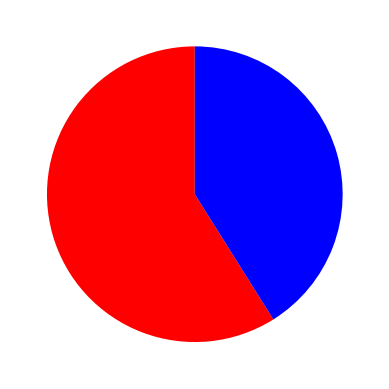

In [252]:
tot_acl = df_acl.shape[0]
tot_arx = df_arx.shape[0]
tot = tot_acl + tot_arx

print(tot_acl, tot_acl / tot)
print(tot_arx, tot_arx / tot)

plt.pie([df_acl.shape[0], df_arx.shape[0]], startangle = 90, counterclock = True, colors = ["red", "blue"], radius = 1)
plt.show()

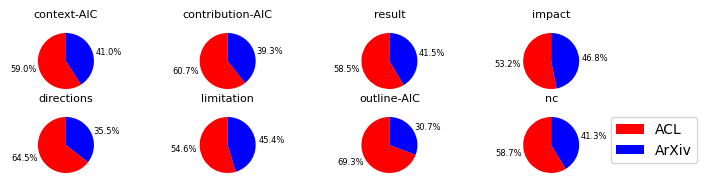

In [254]:
fig, axes = plt.subplots(2, 4, figsize = (8, 2))
for i, label in enumerate(LABELS):
    ax = axes[i // 4, i % 4]
    vals = [df_counts_list[0].at[label, "total"], df_counts_list[1].at[label, "total"]]
    freqs = [str(round(100 * vals[0] / sum(vals), 1))+ "%",str( round(100 * vals[1] / sum(vals), 1)) + "%"]
    ax.pie([df_counts_list[0].at[label, "total"], df_counts_list[1].at[label, "total"]],
           labels = freqs,
           colors = ["red", "blue"],
          startangle = 90,
          counterclock = True,
           #textprops = {"color": "white",},
           #wedgeprops = dict(width = 0.5),
          )
    ax.set_title(label, fontsize = 8)

plt.legend(["ACL", "ArXiv"],
          bbox_to_anchor = (1.25,1))
plt.savefig("acl-arx-categ-distri.png", dpi = 200, bbox_inches = "tight")
plt.show()

In [122]:
# df_counts = df_counts.sort_values(by = "total", ascending = False)
# df_counts_rel = df_counts.copy()
# for label in LABELS:
#     for col in df_counts_rel.columns:
#         if col != "total":
#             df_counts_rel.at[label, col] = str(df_counts.at[label, col]) + f" ({round(df_counts_norm.at[label, col] * 100, 1)}%)"
#         else:
#             df_counts_rel.at[label, col] = str(df_counts.at[label, col]) + f" ({round(df_counts.at[label, col] / df_counts['total'].sum() * 100, 1)}%)"
# s = df_counts_rel[[1,2,3,4, "total"]].to_latex()
# s = re.sub("\(", "{\\\\footnote,size (", s)
# s = re.sub("\)", ")}", s)
# s = re.sub("%", "\%", s)
# print(s)

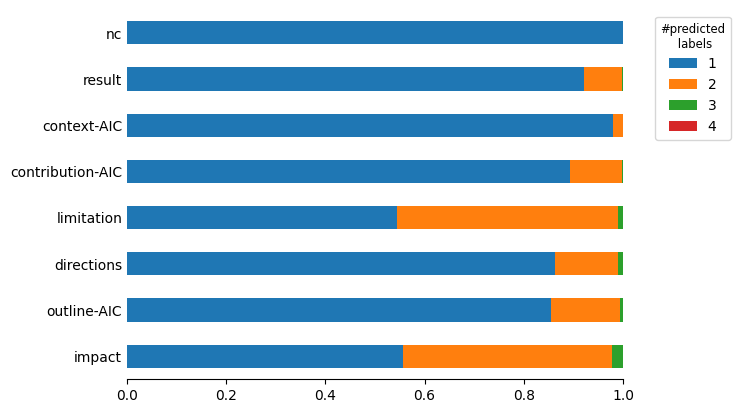

In [34]:
ax = df_counts_norm[range(1, 5)].plot(kind = "barh", stacked = True)
for i, spine in enumerate(ax.spines.values()):
    if i==2:
        continue
    spine.set_visible(False)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.tick_params(axis = "y", which = "both", length = 0)
leg = plt.legend(bbox_to_anchor = (1.05, 1), title = "#predicted\n labels", title_fontsize = "small")
leg.get_title().set_ha("center")
plt.savefig("../results/categ-multi-distri-inf.png", dpi = 300, bbox_inches= "tight")
plt.show()

### On the annotated dataset

In [33]:
df_anno[df_anno["label_anno"].apply(lambda x: len(x) > 1)].shape

(595, 20)

In [28]:
len(df[(df["label_anno"].apply(lambda x: len(x) > 0))]["sentence"].unique().tolist())

14792

In [30]:
df_anno = df[df["label_anno"].apply(lambda x: len(x) > 0)]
print(df_anno.shape)
df_anno = df_anno.drop_duplicates(subset = "sentence")
print(df_anno.shape)

(15357, 20)
(14792, 20)


In [12]:
anno_ids = list(df[df["label_anno"].apply(lambda x: x!= [])]["paper_id"].unique())
print(len(anno_ids))

sources = [df_papers[df_papers["paper_id"] == p_id]["source"].values[0] for p_id in anno_ids]
years = [df_papers[df_papers["paper_id"] == p_id]["year"].values[0] for p_id in anno_ids]

158


In [14]:
from collections import Counter

print(Counter(sources))
print(Counter(years))

Counter({'ACL': 83, 'arXiv': 75})
Counter({2013: 14, 1996: 10, 2012: 9, 2020: 9, 2023: 9, 1992: 7, 1998: 6, 2003: 6, 1991: 6, 1993: 5, 2009: 5, 1999: 5, 2011: 5, 2007: 4, 1994: 4, 2000: 4, 2015: 4, 2016: 4, 2018: 4, 2001: 4, 1997: 4, 2010: 4, 2022: 4, 1989: 3, 2019: 3, 2024: 3, 1995: 3, 1990: 2, 2021: 2, 2008: 1, 2014: 1, 2017: 1, 1987: 1, 2002: 1, 2004: 1})


In [21]:
print(len([y for y in years if y < 1994]) / 158)
print(len([y for y in years if 1994 <= y and y < 2004]) / 158)
print(len([y for y in years if 2004 <= y and y < 2014]) / 158)
print(len([y for y in years if 2014 <= y]) / 158)

0.1518987341772152
0.2974683544303797
0.2721518987341772
0.27848101265822783


In [19]:
years[0] > 1994

False

In [31]:
counts_anno = {i+1:[] for i in range(len(LABELS))}

for label in LABELS:
    occurrences = df_anno[df_anno["label_anno"].apply(lambda x: label in x)].label_anno.values.tolist()
    for i in range(len(LABELS)):
        occ_i = [occ for occ in occurrences if len(occ) == i+1]
        counts_anno[i+1].append(len(occ_i))

df_counts_anno = pd.DataFrame(counts_anno, index = LABELS)
totals_anno = []
for label in LABELS:
    t = sum([df_counts_anno.at[label, i+1] for i in range(len(LABELS))])
    totals_anno.append(t)

df_counts_anno["total"] = totals_anno

df_counts_anno

1    2   3  4  5  6  7  8  total
context-AIC       2131   41   2  0  0  0  0  0   2174
contribution-AIC  1679  240  10  0  0  0  0  0   1929
result            3042  400  11  0  0  0  0  0   3453
impact              66   78   6  0  0  0  0  0    150
directions         365   68   3  0  0  0  0  0    436
limitation         273  260   6  0  0  0  0  0    539
outline-AIC        263   75   4  0  0  0  0  0    342
nc                6378    0   0  0  0  0  0  0   6378

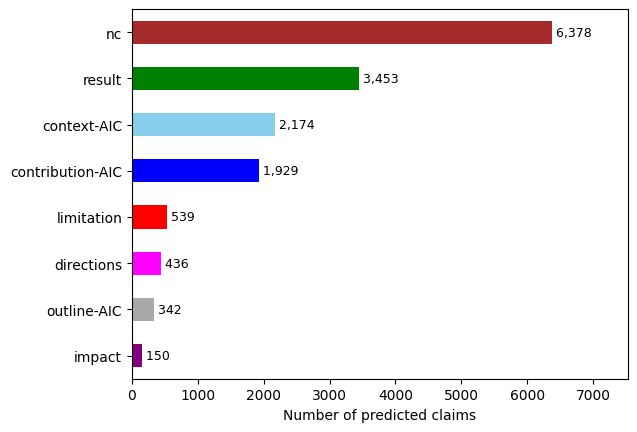

In [32]:
colors = {"nc": "brown",
          "result": "green",
          "context-AIC": "skyblue",
          "contribution-AIC": "blue",
          "limitation": "red",
          "directions": "magenta",
          "outline-AIC": "darkgrey",
          "impact": "purple",
         }

df_counts_anno = df_counts_anno.sort_values(by = "total")
palette = [colors[label] for label in df_counts_anno.index]
ax = df_counts_anno["total"].plot(kind = "barh", color = palette)
# plt.set_yticks([i for i in range(10)])

for i, label in enumerate(df_counts_anno.index):
    count = df_counts_anno.at[label, "total"]
    count_s =  "{:,}".format(int(count))
    plt.text(count, i, f" {count_s}", va = "center", fontsize = 9)
ax.set_xlim(0, df_counts_anno["total"].max() * 1.18)
plt.xlabel("Number of predicted claims")
#plt.ylabel("Claim category")
plt.savefig("../results/pred-claims-distribution-anno.png", dpi = 300, bbox_inches= "tight")
plt.show()

In [38]:
df_counts_norm_anno = df_counts_anno.copy()
for col in df_counts_norm_anno.columns:
    df_counts_norm_anno[col] = df_counts_norm_anno[col] / df_counts_norm_anno["total"]

df_counts_norm_anno

1         2         3    4    5    6    7    8  total
impact            0.435065  0.525974  0.038961  0.0  0.0  0.0  0.0  0.0    1.0
outline-AIC       0.768617  0.215426  0.015957  0.0  0.0  0.0  0.0  0.0    1.0
directions        0.836645  0.156733  0.006623  0.0  0.0  0.0  0.0  0.0    1.0
limitation        0.515315  0.473874  0.010811  0.0  0.0  0.0  0.0  0.0    1.0
contribution-AIC  0.869587  0.124508  0.005906  0.0  0.0  0.0  0.0  0.0    1.0
context-AIC       0.980035  0.019077  0.000887  0.0  0.0  0.0  0.0  0.0    1.0
result            0.880459  0.115901  0.003639  0.0  0.0  0.0  0.0  0.0    1.0
nc                1.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0    1.0

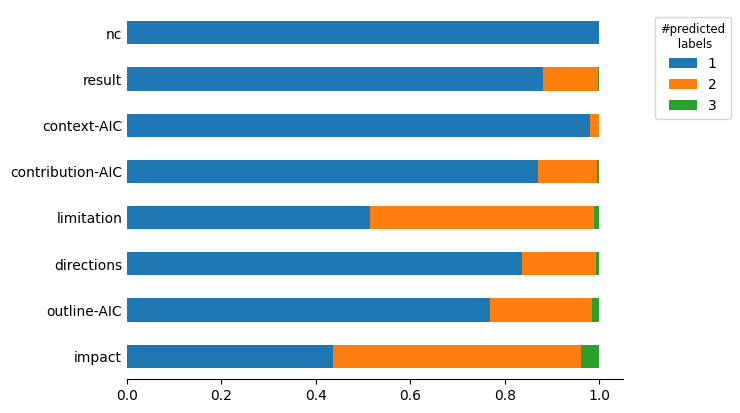

In [39]:
ax = df_counts_norm_anno[range(1, 4)].plot(kind = "barh", stacked = True)
for i, spine in enumerate(ax.spines.values()):
    if i==2:
        continue
    spine.set_visible(False)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.tick_params(axis = "y", which = "both", length = 0)
leg = plt.legend(bbox_to_anchor = (1.05, 1), title = "#predicted\n labels", title_fontsize = "small")
leg.get_title().set_ha("center")
plt.savefig("../results/categ-multi-distri-anno.png", dpi = 300, bbox_inches= "tight")
plt.show()

## Label cooccurrences

### On inferred dataset

In [41]:
from tqdm import tqdm
cooc = np.zeros((len(LABELS), len(LABELS)), dtype = np.int64)

for i, label_1 in tqdm(enumerate(LABELS), total = len(LABELS)):
    for j, label_2 in enumerate(LABELS):

        if i<j:

            cooc_counts = df[df["label_pred"].apply(lambda x: label_1 in x and label_2 in x)].shape[0]
            cooc[i, j] = cooc_counts

100%|██████████| 8/8 [01:42<00:00, 12.77s/it]


In [42]:
for i, label_1 in enumerate(LABELS):
    for j, label_2 in enumerate(LABELS):

        if i<j:
            continue
        elif i==j:
            cooc[i, j] = df_counts.at[label_1, 1]
        else:
            cooc[i, j] = cooc[j, i]

print(cooc)

NameError: name 'df_counts' is not defined

In [42]:
cooc_ratios = cooc.copy().astype(np.float64)

for i, label_1 in enumerate(LABELS):
    for j, label_2 in enumerate(LABELS):
        cooc_ratios[i, j] = cooc[i, j] / df_counts.at[label_1, "total"]

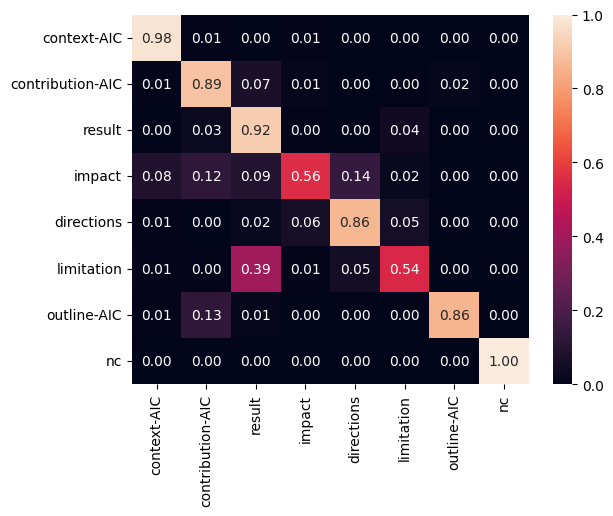

In [43]:
ax = sns.heatmap(cooc_ratios, annot = True, fmt = ".2f", xticklabels = LABELS, yticklabels = LABELS)
plt.savefig("../results/cooc-heatmap-inf.png", dpi = 300, bbox_inches= "tight")

### On annotated dataset

In [473]:
cooc_anno = np.zeros((len(LABELS), len(LABELS)), dtype = np.int64)

for i, label_1 in tqdm(enumerate(LABELS), total = len(LABELS)):
    for j, label_2 in enumerate(LABELS):

        if i<j:

            cooc_counts = df[df["label_anno"].apply(lambda x: label_1 in x and label_2 in x)].shape[0]
            cooc_anno[i, j] = cooc_counts

100%|██████████| 8/8 [00:58<00:00,  7.31s/it]


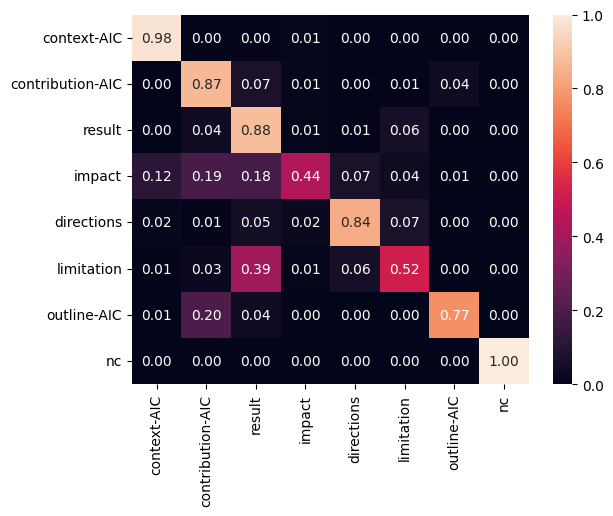

In [474]:
for i, label_1 in enumerate(LABELS):
    for j, label_2 in enumerate(LABELS):

        if i<j:
            continue
        elif i==j:
            cooc_anno[i, j] = df_counts_anno.at[label_1, 1]
        else:
            cooc_anno[i, j] = cooc_anno[j, i]

cooc_ratios_anno = cooc_anno.copy().astype(np.float64)

for i, label_1 in enumerate(LABELS):
    for j, label_2 in enumerate(LABELS):
        cooc_ratios_anno[i, j] = cooc_anno[i, j] / df_counts_anno.at[label_1, "total"]

ax = sns.heatmap(cooc_ratios_anno, annot = True, fmt = ".2f", xticklabels = LABELS, yticklabels = LABELS)
plt.savefig("../results/cooc-heatmap-anno.png", dpi = 300, bbox_inches= "tight")


## Labels and papers

In [11]:
df_papers = pd.read_csv("papers.csv")
df_papers.head()

/tmp/ipykernel_47106/1400073408.py:1: DtypeWarning: Columns (6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_papers = pd.read_csv("papers.csv")


paper_id        id source  \
0         0  O02-2002    ACL   
1         1  R13-1042    ACL   
2         2  R13-1044    ACL   
3         3  W05-0818    ACL   
4         4  R13-1045    ACL   

                                               title  \
0  A Study on Word Similarity using Context Vecto...   
1  Headerless, Quoteless, but not Hopeless? Using...   
2  Recognizing semantic relations within {P}olish...   
3            {LIHLA}: Shared Task System Description   
4  Unsupervised Induction of {A}rabic Root and Pa...   

                                             authors  year  \
0       [['Chen', 'Keh-Jiann'], ['You', 'Jia-Ming']]  2002   
1      [['Jamison', 'Emily'], ['Gurevych', 'Iryna']]  2013   
2  [['K{\\k{e}}dzia', 'Pawe{\\l}'], ['Maziarz', '...  2013   
3  [['Caseli', 'Helena M.'], ['Nunes', 'Maria G. ...  2005   
4         [['Khaliq', 'Bilal'], ['Carroll', 'John']]  2013   

                                   publisher  \
0                                        NaN   
1              INCOMA Ltd. Shoumen, BULGARIA   
2              INCOMA Ltd. Shoumen, BULGARIA   
3  Association for Computational Linguistics   
4              INCOMA Ltd. Shoumen, BULGARIA   

                                            category  num_cited_by  \
0                                                NaN          14.0   
1      Computational Social Science and Social Media          10.0   
2  Semantics: Sentence-level Semantics, Textual I...           2.0   
3                                                NaN           5.0   
4        Phonology, Morphology and Word Segmentation           2.0   

           xml_path  ...  nb_pred_claims  #context-AIC #contribution-AIC  \
0  O02-2002.tei.xml  ...              62            19                15   
1  R13-1042.tei.xml  ...              79            15                 7   
2  R13-1044.tei.xml  ...              25             4                 4   
3  W05-0818.tei.xml  ...              21             3                 3   
4  R13-1045.tei.xml  ...              39             9                14   

   #result  #impact  #directions  #limitation  #outline-AIC  #nc  \
0       24        1            1            6             0  127   
1       43        0            1           15             0  113   
2       14        0            2            1             0  123   
3       11        0            3            1             1   37   
4       11        1            1            2             4  112   

   claims_to_sents_ratio  
0               0.328042  
1               0.411458  
2               0.168919  
3               0.362069  
4               0.258278  

[5 rows x 24 columns]

In [45]:
df_papers[df_papers["annotated"] == True][["nb_sentences"]].describe()

nb_sentences
count    158.000000
mean     194.765823
std      115.562935
min       50.000000
25%      123.500000
50%      173.000000
75%      222.750000
max      737.000000

In [260]:
df_papers[(df_papers["annotated"] == False) & (df_papers["source"] == "arXiv")]["nb_sentences"].describe()

count    33740.000000
mean       192.503408
std        165.816211
min          0.000000
25%        113.000000
50%        180.000000
75%        248.000000
max       8548.000000
Name: nb_sentences, dtype: float64

In [261]:
df_papers[(df_papers["annotated"] == False) & (df_papers["source"] == "ACL")]["nb_sentences"].describe()

count    71203.000000
mean       130.963176
std         83.839823
min          0.000000
25%         83.000000
50%        137.000000
75%        191.000000
max       1813.000000
Name: nb_sentences, dtype: float64

In [47]:
df_papers[df_papers["annotated"] == True][["nb_pred_claims"]].describe()

nb_pred_claims
count      158.000000
mean       153.018987
std         99.891372
min         24.000000
25%         88.250000
50%        129.500000
75%        174.750000
max        698.000000

In [48]:
df_papers[(df_papers["annotated"] == False) & (df_papers["nb_sentences"] != 0)][["nb_pred_claims"]].describe()

nb_pred_claims
count    87609.000000
mean        63.630928
std         33.430120
min          0.000000
25%         43.000000
50%         59.000000
75%         78.000000
max       2262.000000

In [49]:
from collections import Counter
data = {l: [] for l in LABELS}

for i, row in tqdm(df_papers.iterrows(), total = df_papers.shape[0]):
    paper_id = row["paper_id"]
    paper_labels = []
    paper_sents = df[df["paper_id"] == paper_id]
    for labels in paper_sents["label_pred"].values.tolist():
        for l in labels:
            paper_labels.append(l)
            
    counter = Counter(paper_labels)
    
    for label in LABELS:
        data[label].append(counter[label])

100%|██████████| 105101/105101 [31:50<00:00, 55.00it/s]


In [50]:
for label in LABELS:
    df_papers[f"#{label}"] = data[label]

df_papers

paper_id              id source  \
0              0        O02-2002    ACL   
1              1        R13-1042    ACL   
2              2        R13-1044    ACL   
3              3        W05-0818    ACL   
4              4        R13-1045    ACL   
...          ...             ...    ...   
105096    105096  cmp-lg/9708011  arXiv   
105097    105097      cs/0412114  arXiv   
105098    105098      cs/0601005  arXiv   
105099    105099      cs/9811003  arXiv   
105100    105100      cs/9907004  arXiv   

                                                    title  \
0       A Study on Word Similarity using Context Vecto...   
1       Headerless, Quoteless, but not Hopeless? Using...   
2       Recognizing semantic relations within {P}olish...   
3                 {LIHLA}: Shared Task System Description   
4       Unsupervised Induction of {A}rabic Root and Pa...   
...                                                   ...   
105096  Similarity-Based Approaches to Natural Languag...   
105097  State of the Art, Evaluation and Recommendatio...   
105098  Analyzing language development from a network ...   
105099  A Winnow-Based Approach to Context-Sensitive S...   
105100  MAP Lexicon is useful for segmentation and wor...   

                                                  authors  year  \
0            [['Chen', 'Keh-Jiann'], ['You', 'Jia-Ming']]  2002   
1           [['Jamison', 'Emily'], ['Gurevych', 'Iryna']]  2013   
2       [['K{\\k{e}}dzia', 'Pawe{\\l}'], ['Maziarz', '...  2013   
3       [['Caseli', 'Helena M.'], ['Nunes', 'Maria G. ...  2005   
4              [['Khaliq', 'Bilal'], ['Carroll', 'John']]  2013   
...                                                   ...   ...   
105096                               [['Lee', 'Lillian']]  1997   
105097  [['Rajman', 'Martin'], ['Vesely', 'Martin'], [...  2004   
105098                     [['Ke', 'J-Y'], ['Yao', 'Y.']]  2006   
105099        [['Golding', 'Andrew R.'], ['Roth', 'Dan']]  1998   
105100                        [['Venkataraman', 'Anand']]  1999   

                                        publisher  \
0                                             NaN   
1                   INCOMA Ltd. Shoumen, BULGARIA   
2                   INCOMA Ltd. Shoumen, BULGARIA   
3       Association for Computational Linguistics   
4                   INCOMA Ltd. Shoumen, BULGARIA   
...                                           ...   
105096                                        NaN   
105097                                        NaN   
105098                                        NaN   
105099                                        NaN   
105100                                        NaN   

                                                 category  num_cited_by  \
0                                                     NaN          14.0   
1           Computational Social Science and Social Media          10.0   
2       Semantics: Sentence-level Semantics, Textual I...           2.0   
3                                                     NaN           5.0   
4             Phonology, Morphology and Word Segmentation           2.0   
...                                                   ...           ...   
105096                                ['cmp-lg', 'cs.CL']           NaN   
105097                                          ['cs.CL']           NaN   
105098                                          ['cs.CL']           NaN   
105099                                 ['cs.LG', 'cs.CL']           NaN   
105100                                 ['cs.CL', 'cs.LG']           NaN   

                        xml_path  ...  nb_sentences  nb_pred_claims  \
0               O02-2002.tei.xml  ...           189              62   
1               R13-1042.tei.xml  ...           192              79   
2               R13-1044.tei.xml  ...           148              25   
3               W05-0818.tei.xml  ...            58              21   
4               R13-1045.tei.xml  ...           151         

In [51]:
df_papers[df_papers["source"] == "arXiv"]

paper_id              id source  \
71286      71286       1001.4368  arXiv   
71287      71287       1002.0481  arXiv   
71288      71288       1002.1095  arXiv   
71289      71289       1003.0628  arXiv   
71290      71290       1006.3271  arXiv   
...          ...             ...    ...   
105096    105096  cmp-lg/9708011  arXiv   
105097    105097      cs/0412114  arXiv   
105098    105098      cs/0601005  arXiv   
105099    105099      cs/9811003  arXiv   
105100    105100      cs/9907004  arXiv   

                                                    title  \
71286   Implicit media frames: Automated analysis of p...   
71287   Recognition and translation Arabic-French of N...   
71288   Towards a Heuristic Categorization of Preposit...   
71289   Linguistic Geometries for Unsupervised Dimensi...   
71290   The probabilistic analysis of language acquisi...   
...                                                   ...   
105096  Similarity-Based Approaches to Natural Languag...   
105097  State of the Art, Evaluation and Recommendatio...   
105098  Analyzing language development from a network ...   
105099  A Winnow-Based Approach to Context-Sensitive S...   
105100  MAP Lexicon is useful for segmentation and wor...   

                                                  authors  year publisher  \
71286   [['Hellsten', 'Iina'], ['Dawson', 'James'], ['...  2010       NaN   
71287   [['Hamadou', 'Abdelmajid Ben'], ['Piton', 'Odi...  2010       NaN   
71288    [['Rudzicz', 'Frank'], ['Mokhov', 'Serguei A.']]  2010       NaN   
71289   [['Mao', 'Yi'], ['Balasubramanian', 'Krishnaku...  2010       NaN   
71290   [['Hsu', 'Anne S.'], ['Chater', 'Nick'], ['Vit...  2010       NaN   
...                                                   ...   ...       ...   
105096                               [['Lee', 'Lillian']]  1997       NaN   
105097  [['Rajman', 'Martin'], ['Vesely', 'Martin'], [...  2004       NaN   
105098                     [['Ke', 'J-Y'], ['Yao', 'Y.']]  2006       NaN   
105099        [['Golding', 'Andrew R.'], ['Roth', 'Dan']]  1998       NaN   
105100                        [['Venkataraman', 'Anand']]  1999       NaN   

                                        category  num_cited_by  \
71286                         ['cs.IR', 'cs.CL']           NaN   
71287                                  ['cs.CL']           NaN   
71288                                  ['cs.CL']           NaN   
71289                                  ['cs.CL']           NaN   
71290   ['cs.CL', 'physics.data-an', 'q-bio.NC']           NaN   
...                                          ...           ...   
105096                       ['cmp-lg', 'cs.CL']           NaN   
105097                                 ['cs.CL']           NaN   
105098                                 ['cs.CL']           NaN   
105099                        ['cs.LG', 'cs.CL']           NaN   
105100                        ['cs.CL', 'cs.LG']           NaN   

                          xml_path  ...  nb_sentences  nb_pred_claims  \
71286   1001.4368v1.grobid.tei.xml  ...           600             206   
71287   1002.0481v2.grobid.tei.xml  ...           278             266   
71288   1002.1095v1.grobid.tei.xml  ...           292              90   
71289   1003.0628v1.grobid.tei.xml  ...           358             102   
71290   1006.3271v1.grobid.tei.xml  ...           418             334   
...                            ...  ...           ...             ...   
105096    9708011v1.grobid.tei.xml  ...             0               0   
105097    0412114v1.grobid.tei.xml  ...             0               0   
105098    0601005v1.grobid.tei.xml  ...             0               0   
105099    9811003v1.grobid.tei.xml  ...             0               0   
105100    9907004v1.grobid.tei.xml  ...             0               0   

       #context-AIC  #contribution-AIC  #result  #impact  #directions  \
71286            62                 26       94       18           14   
71287            

In [58]:
df_papers.to_csv("papers.csv", index = False)

In [53]:
df_papers["claims_to_sents_ratio"] = df_papers.apply(lambda x: x["nb_pred_claims"] / x["nb_sentences"] if x["nb_sentences"] != 0 else 0, axis = 1)
df_papers.head()

paper_id        id source  \
0         0  O02-2002    ACL   
1         1  R13-1042    ACL   
2         2  R13-1044    ACL   
3         3  W05-0818    ACL   
4         4  R13-1045    ACL   

                                               title  \
0  A Study on Word Similarity using Context Vecto...   
1  Headerless, Quoteless, but not Hopeless? Using...   
2  Recognizing semantic relations within {P}olish...   
3            {LIHLA}: Shared Task System Description   
4  Unsupervised Induction of {A}rabic Root and Pa...   

                                             authors  year  \
0       [['Chen', 'Keh-Jiann'], ['You', 'Jia-Ming']]  2002   
1      [['Jamison', 'Emily'], ['Gurevych', 'Iryna']]  2013   
2  [['K{\\k{e}}dzia', 'Pawe{\\l}'], ['Maziarz', '...  2013   
3  [['Caseli', 'Helena M.'], ['Nunes', 'Maria G. ...  2005   
4         [['Khaliq', 'Bilal'], ['Carroll', 'John']]  2013   

                                   publisher  \
0                                        NaN   
1              INCOMA Ltd. Shoumen, BULGARIA   
2              INCOMA Ltd. Shoumen, BULGARIA   
3  Association for Computational Linguistics   
4              INCOMA Ltd. Shoumen, BULGARIA   

                                            category  num_cited_by  \
0                                                NaN          14.0   
1      Computational Social Science and Social Media          10.0   
2  Semantics: Sentence-level Semantics, Textual I...           2.0   
3                                                NaN           5.0   
4        Phonology, Morphology and Word Segmentation           2.0   

           xml_path  ...  nb_pred_claims  #context-AIC #contribution-AIC  \
0  O02-2002.tei.xml  ...              62            19                15   
1  R13-1042.tei.xml  ...              79            15                 7   
2  R13-1044.tei.xml  ...              25             4                 4   
3  W05-0818.tei.xml  ...              21             3                 3   
4  R13-1045.tei.xml  ...              39             9                14   

   #result  #impact  #directions  #limitation  #outline-AIC  #nc  \
0       24        1            1            6             0  127   
1       43        0            1           15             0  113   
2       14        0            2            1             0  123   
3       11        0            3            1             1   37   
4       11        1            1            2             4  112   

   claims_to_sents_ratio  
0               0.328042  
1               0.411458  
2               0.168919  
3               0.362069  
4               0.258278  

[5 rows x 24 columns]

In [54]:
df_papers["claims_to_sents_ratio"].describe()

count    105101.000000
mean          0.308717
std           0.172349
min           0.000000
25%           0.236842
50%           0.336842
75%           0.417476
max           1.000000
Name: claims_to_sents_ratio, dtype: float64

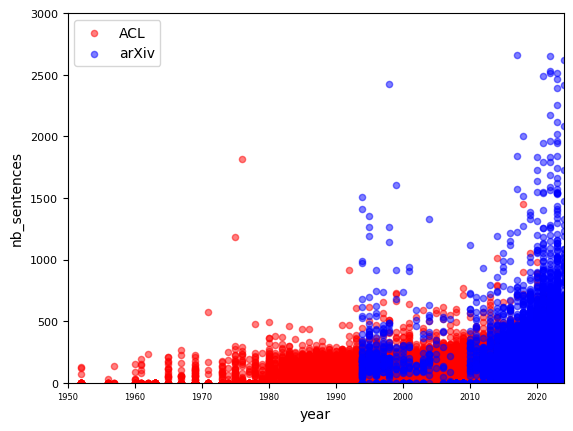

In [113]:
colors = {"ACL": "red", "arXiv": "blue"}
grouped = df_papers.groupby("source")

for key, group in grouped:
    group.plot(x = "year", y = "nb_sentences", kind = "scatter", ylim = (0, 3000), xlim = (1950, 2024), label = key, color = colors[key], ax = plt.gca(), alpha = 0.5)

plt.savefig("../results/years-source-sents_counts.png", dpi = 300, bbox_inches= "tight")


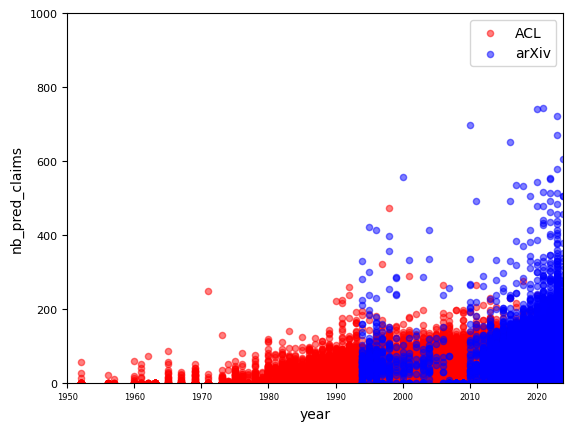

In [114]:
colors = {"ACL": "red", "arXiv": "blue"}
grouped = df_papers.groupby("source")

for key, group in grouped:
    group.plot(x = "year", y = "nb_pred_claims", kind = "scatter", ylim = (0, 1000), xlim = (1950, 2024), label = key, color = colors[key], ax = plt.gca(), alpha = 0.5)

plt.savefig("../results/years-source-claims_counts.png", dpi = 300, bbox_inches= "tight")


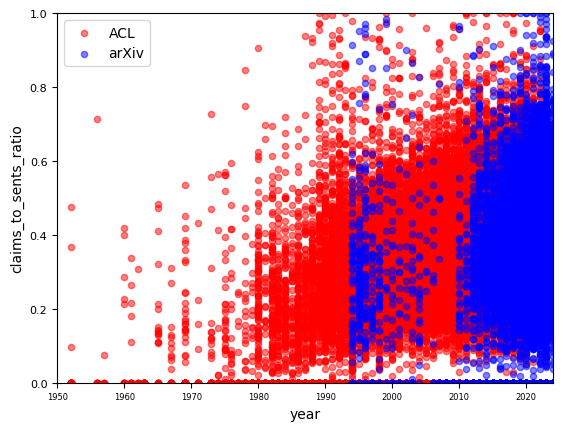

In [115]:
colors = {"ACL": "red", "arXiv": "blue"}
grouped = df_papers.groupby("source")

for key, group in grouped:
    group.plot(x = "year", y = "claims_to_sents_ratio", kind = "scatter", ylim = (0, 1), xlim = (1950, 2024), label = key, color = colors[key], ax = plt.gca(), alpha = 0.5)

plt.savefig("../results/years-source-cs_ratio.png", dpi = 300, bbox_inches= "tight")


## Certainty

In [12]:
df["sentence_certainty"].describe()

count    1.585081e+07
mean     4.800126e+00
std      3.814795e-01
min      2.145219e+00
25%      4.767665e+00
50%      4.929266e+00
75%      4.990518e+00
max      5.970514e+00
Name: sentence_certainty, dtype: float64

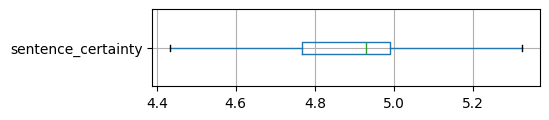

In [25]:
fig, ax = plt.subplots(figsize = (5, 1))

df.boxplot("sentence_certainty", showfliers = False, vert = False)
#ax.set_xlabel("sentence-level certainty")
#ax.set_xlim(1,6)
plt.show()

In [29]:
sorted = df.sort_values(by = "sentence_certainty", ascending = True)

In [32]:
sorted[["sentence", "sentence_certainty"]][:2].values.tolist()

[['However, there is still much room for future research, as the state-of-the-art model on the Fever shared task achieves an accuracy score of 68.21% (Thorne et al., 2018b). ',
  2.14521861076355],
 ['While much recent work has focused on coherence for response generation (Serban et al., 2016;Li et al., 2016;Yi et al., 2019), we argue that there is still much to be understood regarding the mechanisms and substructures that affect human perception of dialogue coherence.',
  2.3213744163513184]]

In [33]:
rev = sorted[::-1]
rev[["sentence", "sentence_certainty"]][:2].values.tolist()

[["For downward tracing there is no problem with deletion rules using '0' or '[]', whether they are conditioned by an environment or not, and tracing apply-down application of epenthesis rules with an environment is likewise unproblematic.",
  5.970513820648193],
 ['There are no sentences expressing conflicting opinions about aspect terms (e.g., "The screen is clear but small"), nor are there any sentences that do not express opinions about their aspect terms (e.g., "It has a 4.8-inch screen").',
  5.967402935028076]]

In [34]:
df[(df["sentence_certainty"] > 3.4) & (df["sentence_certainty"] < 3.6)][["sentence", "sentence_certainty"]][:2].values.tolist()

[['e) Words with similar contexts might not be synonyms:', 3.5246329307556152],
 ["In response to the question, Which room is Monday's meeting in?, there may be no way to choose between A101 and A201 without further world knowledge. ",
  3.4801127910614014]]

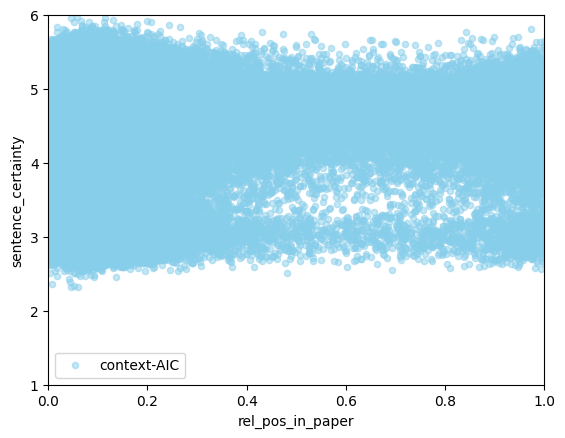

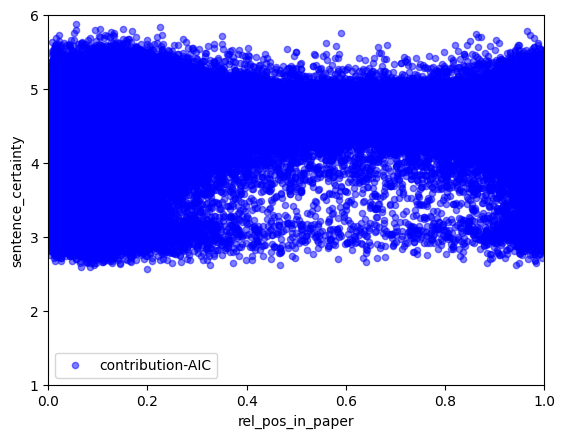

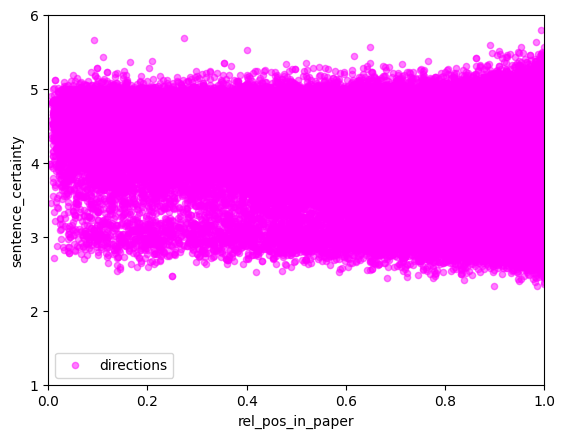

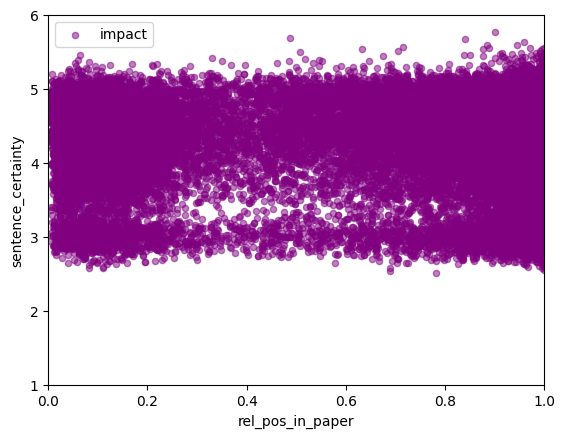

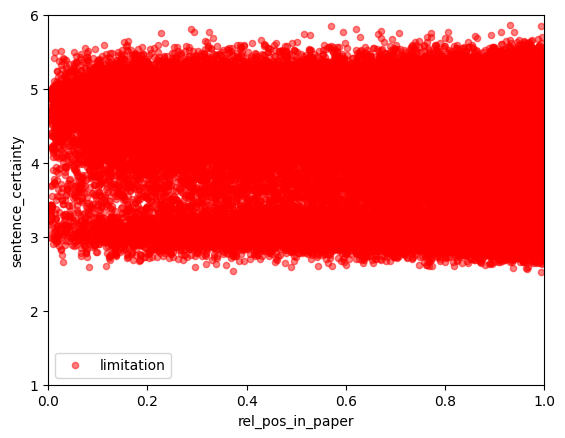

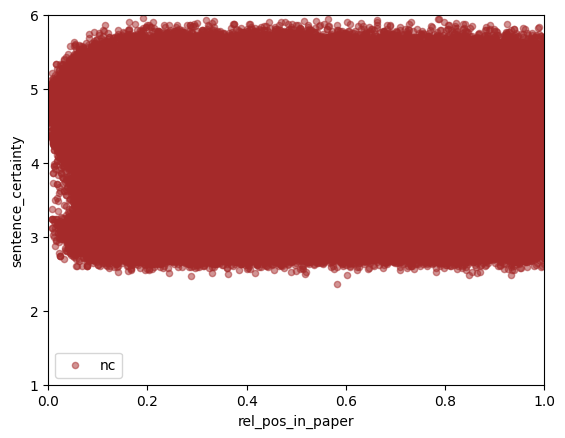

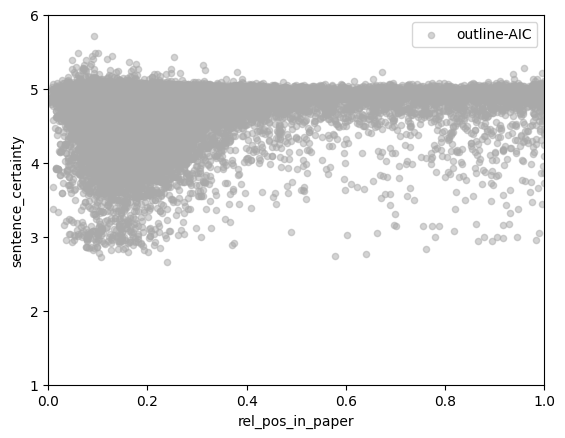

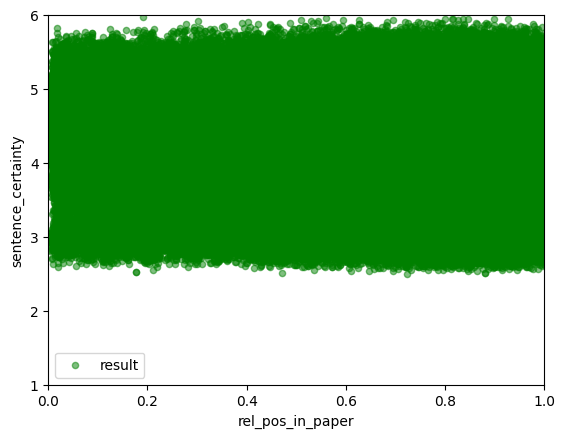

In [7]:
colors = {"nc": "brown",
          "result": "green",
          "context-AIC": "skyblue",
          "contribution-AIC": "blue",
          "limitation": "red",
          "directions": "magenta",
          "outline-AIC": "darkgrey",
          "impact": "purple",
         }
grouped = df.groupby("unique_label")

for key, group in grouped:
    if key != "mixed":
        group.plot(x = "rel_pos_in_paper", y = "sentence_certainty", kind = "scatter", ylim = (1, 6), xlim = (0, 1), label = key, color = colors[key], alpha = 0.5)


plt.show()

In [11]:
for label in LABELS:
    print(label)
    subdf = df[df["unique_label"] == label][["sentence_certainty", "rel_pos_in_paper"]]
    coef = subdf.corr(method = "pearson").at["rel_pos_in_paper", "sentence_certainty"]
    print(coef)

context-AIC
0.03509686524722003
contribution-AIC
0.033809657437656696
result
-0.009640567193845385
impact
0.03998212222469283
directions
-0.10806604670063724
limitation
-0.012978720975340087
outline-AIC
-0.01822562930853875
nc
0.06721706553084991


<Axes: xlabel='rel_pos_in_paper', ylabel='sentence_certainty'>

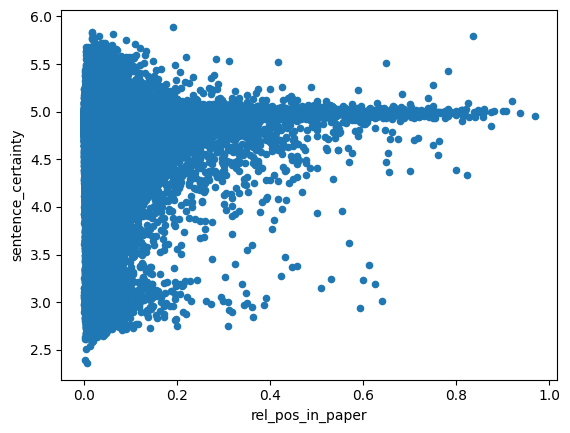

In [86]:
df["rel_pos_in_paper"] = df.apply(lambda x: (x["sent_id_in_paper"] + 1) / df_papers.at[x["paper_id"], "nb_sentences"] , axis = 1) 
abs = df[df["section"] == "abstract"]
abs.plot(x = "rel_pos_in_paper", y = "sentence_certainty", kind = "scatter")

In [349]:
# df["unique_label"] = df["label_pred"A].apply(lambda x: x[0] if len(x) == 1 else "mixed")

<Axes: title={'center': 'sentence_certainty'}, ylabel='unique_label'>

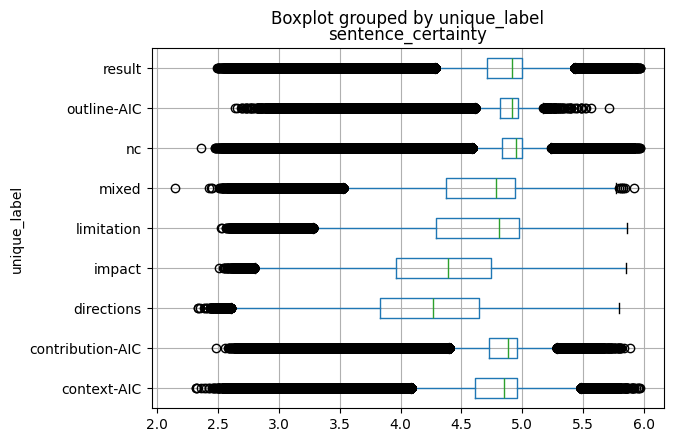

In [87]:
df.boxplot("sentence_certainty", by = "unique_label", vert = False, label = "")

In [63]:
df["source"] = df["paper_id"].apply(lambda x: df_papers.at[x, "source"])
df

sentence_id  paper_id  sent_id_in_paper  \
0                   0         0                 0   
1                   1         0                 1   
2                   2         0                 2   
3                   3         0                 3   
4                   4         0                 4   
...               ...       ...               ...   
15850804     15850802    104542               907   
15850805     15850803    104542               908   
15850806     15850804    104542               909   
15850807     15850805    104542               910   
15850808     15850806    104542               911   

                                                   sentence     section  \
0         There is a need to measure word similarity whe...    abstract   
1         Usually, measures of similarity between two wo...    abstract   
2         The taxonomy approaches are more or less seman...    abstract   
3         However, in real applications, both semantic a...    abstract   
4         Word similarity based on context vectors is a ...    abstract   
...                                                     ...         ...   
15850804  This approach then promises to adress the stor...  Discussion   
15850805  Finally, annotations could simply be output st...  Discussion   
15850806  Mohri (1994) has described an algorithm to mak...  Discussion   
15850807  Advantages and disadvantages of this approach ...  Discussion   
15850808  Of course, application of underlying and surfa...  Discussion   

                -2        -1  candidate  sentence_certainty  \
0               -1        -1       True            4.546492   
1               -1         0       True            4.729261   
2                0         1       True            4.835920   
3                1         2       True            4.872213   
4                2         3       True            4.952981   
...            ...       ...        ...                 ...   
15850804  15850800  15850801      False            4.577283   
15850805  15850801  15850802      False            3.967637   
15850806  15850802  15850803      False            4.755935   
15850807  15850803  15850804      False            3.549369   
15850808  15850804  15850805      False            5.020026   

                                           aspect_certainty  ...  \
0         [[Condition, Certain], [Suggestion, Certain], ...  ...   
1             [[Extent, Uncertain], [Probability, Certain]]  ...   
2                                  [[Probability, Certain]]  ...   
3           [[Probability, Certain], [Suggestion, Certain]]  ...   
4                                  [[Probability, Certain]]  ...   
...                                                     ...  ...   
15850804                           [[Probability, Certain]]  ...   
15850805                         [[Probability, Uncertain]]  ...   
15850806                               [[Framing, Certain]]  ...   
15850807  [[Extent, Uncertain], [Probability, Uncertain]...  ...   
15850808    [[Probability, Certain], [Suggestion, Certain]]  ...   

             label_pred rel_pos_in_paper  unique_label  Number     Extent  \
0         [context-AIC]         0.005291   context-AIC  absent     absent   
1         [context-AIC]         0.010582   context-AIC  absent  Uncertain   
2         [context-AIC]         0.015873   context-AIC  absent     absent   
3         [context-AIC]         0.021164   context-AIC  absent     absent   
4         [context-AIC]         0.026455   context-AIC  absent     absent   
...                 ...              ...           ...     ...        ...   
15850804       [result]        -1.000000        result  absent     absent   
15850805       [result]        -1.000000        result  absent     absent   
15850806  [context-AIC]        -1.000000   context-AIC  absent     absent   
15850807           [nc]        -1.000000            nc  absent  Uncertain   
15850808       [result]        -1.000000        res

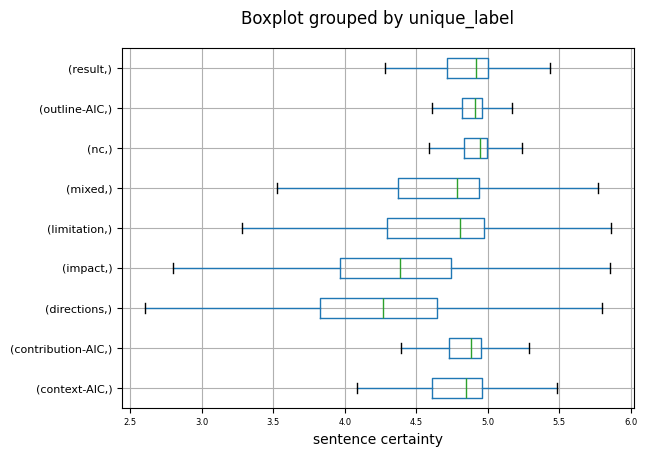

In [125]:
axes = df.boxplot("sentence_certainty", by = ["unique_label"], vert = False, showfliers = False, return_type = "axes")
plt.xlabel("sentence certainty")
plt.ylabel("")
plt.title("")
plt.savefig("../results/cert-claims-boxplots-1.png", dpi = 300, bbox_inches= "tight")
plt.show()

In [173]:
# df_per_label = [df[df["label_pred"].apply(lambda x: x == [label])] for label in LABELS]

In [16]:
# ASPECTS = ["Number", "Extent", "Probability", "Condition", "Framing", "Suggestion"]

# d = {"overall": []}

# # def return_aspect_modality(l, aspect):
# #     for aspect_elt in l:
# #         if aspect_elt[0] == aspect:
# #             return aspect_elt[1]
# #     return "absent"

# # for i, aspect in tqdm(enumerate(ASPECTS), total = len(ASPECTS)):
# #     df[f"{aspect}"] = df["aspect_certainty"].apply(lambda x: return_aspect_modality(x, aspect))

In [218]:
df[aspect].value_counts()

Suggestion
absent       11587585
Certain        838266
Uncertain       94114
Name: count, dtype: int64

In [89]:
d = {"overall": []}
for i, aspect in tqdm(enumerate(ASPECTS), total = len(ASPECTS)):
    counts = df[aspect].value_counts()
    d["overall"].append([counts["Certain"] / df.shape[0], counts["Uncertain"]/ df.shape[0], counts["absent"] / df.shape[0]])

100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


<Axes: >

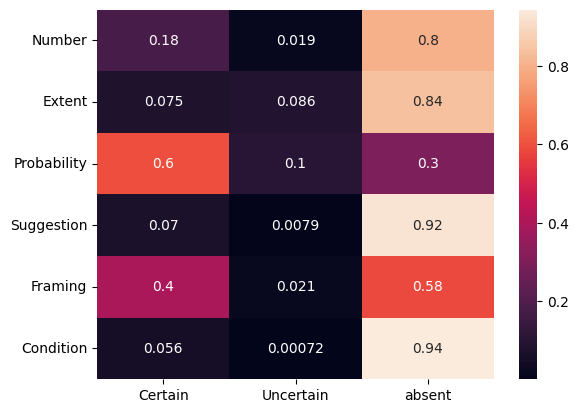

In [90]:
ar = np.array([elt for elt in d["overall"]])
sns.heatmap(ar, annot = True, xticklabels = ["Certain", "Uncertain", "absent"], yticklabels = ASPECTS)

In [91]:
df_aspect = pd.DataFrame(ar, columns = ["Certain", "Uncertain", "Absent"])
df_aspect.index = ASPECTS
df_aspect

Certain  Uncertain    Absent
Number       0.180908   0.018825  0.800267
Extent       0.074795   0.085574  0.839631
Probability  0.595646   0.103581  0.300774
Suggestion   0.069520   0.007935  0.922545
Framing      0.396090   0.020761  0.583149
Condition    0.055721   0.000719  0.943560

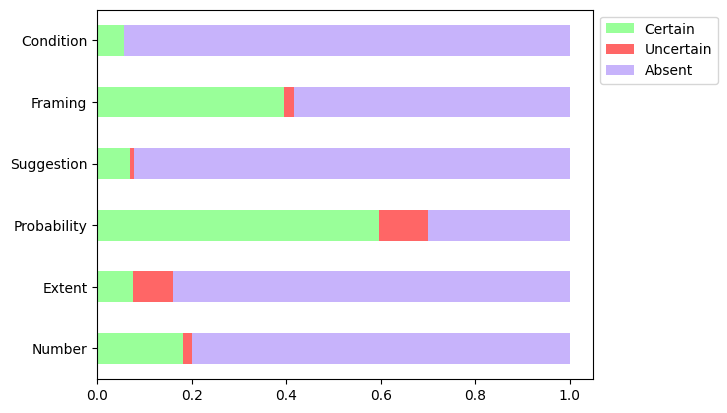

In [93]:
df_aspect.plot(kind = "barh", stacked = True, color = ['#99ff99', '#ff6666', '#c7b3fb'])
plt.legend(bbox_to_anchor = (1,1))
plt.savefig("../results/cert-values.png", dpi = 300, bbox_inches= "tight")
plt.show()

In [94]:
for i, label in enumerate(LABELS):
    d[label] = {}
    for j, aspect in enumerate(ASPECTS):
        d[label][aspect] = {"Certain": 0,
                            "Uncertain": 0,
                            "absent": 0}
        
        counts = df[df["unique_label"] == label].value_counts(aspect)
        
        for pres in ["Certain", "Uncertain", "absent"]:
            try:
                d[label][aspect][pres] += counts[pres]
            except:
                continue

In [95]:
d["result"]

{'Number': {'Certain': 588860, 'Uncertain': 59623, 'absent': 1680790},
 'Extent': {'Certain': 497417, 'Uncertain': 379432, 'absent': 1452424},
 'Probability': {'Certain': 1771389, 'Uncertain': 293264, 'absent': 264620},
 'Suggestion': {'Certain': 63052, 'Uncertain': 5732, 'absent': 2260489},
 'Framing': {'Certain': 1056712, 'Uncertain': 80469, 'absent': 1192092},
 'Condition': {'Certain': 119726, 'Uncertain': 3568, 'absent': 2205979}}

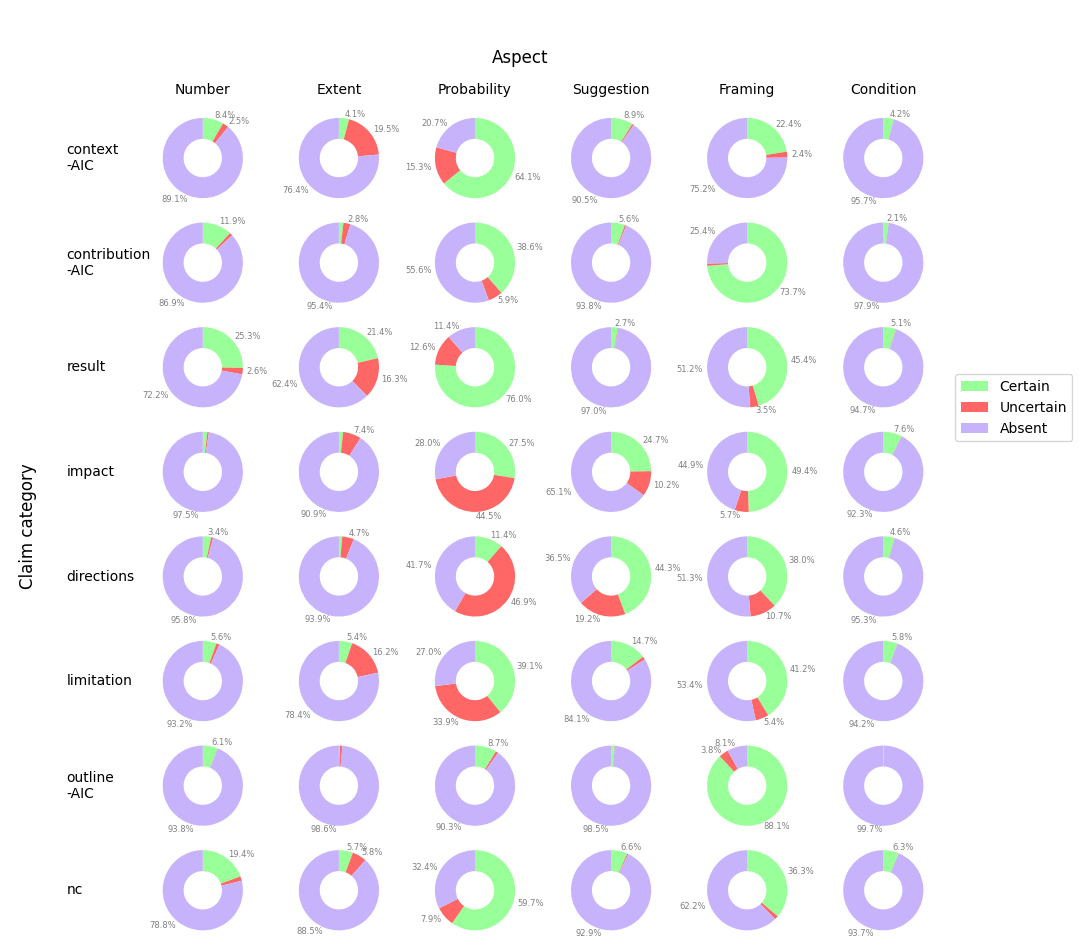

In [96]:
fig, axes = plt.subplots(len(LABELS) + 1 , len(ASPECTS) + 1, figsize = (12, 12))

axes[0, 0].set_axis_off()

for j, aspect in enumerate(ASPECTS):

    ax = axes[0, j+1]
    ax.set_axis_off()
    ax.text(0.5, 0, aspect, ha = "center", va = "bottom")

for i, label in enumerate(LABELS):

    ax = axes[i+1, 0]
    ax.set_axis_off()
    ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center",)
    
    for j, aspect in enumerate(ASPECTS):

        d[aspect] = {}

        # get the corresponding subplot
        ax = axes[i + 1, j+ 1]

        # plot a pie chart
        counts = d[label][aspect]
        vals = [counts["Certain"], counts["Uncertain"], counts["absent"]]
        props = [val / sum(vals) for val in vals]

        t = 0.02
        nb_below_t = len([p for p in props if p < t])

        labels = [str(round(prop * 100, 1)) + "%" if prop > t  else "" for val, prop in zip(vals, props)]
        
                
        ax.pie(x = vals,
               labels = labels,
               counterclock = False,
               textprops = {"fontsize": 6, "color": "grey",},
              colors = ['#99ff99', '#ff6666', '#c7b3fb'],
               wedgeprops = dict(width = 0.6),
               startangle = 90,
               radius = 1.15,
              )

plt.legend(["Certain", "Uncertain", "Absent"],
          bbox_to_anchor = (2.75, 6.5))

# fig.supxlabel("Aspect", y = 1)
# fig.supylabel("Claim category")
# fig.set_tight_layout(True)

xlab = fig.supxlabel("Aspect", ha = "center", va = "center")
xlab.set_position((0.55, 0.84))

ylab = fig.supylabel("Claim category", ha = "center", va = "center")
ylab.set_position((0.14, 0.45))
plt.savefig("../results/category-aspect-pies.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [97]:
df[(df["unique_label"] == "directions") & (df["Suggestion"] == "Certain")].sentence.values.tolist()

['In future work, we will investigate discourse knowledge, highly-tuned stylistic features, and other email-specific features to improve headerless, quoteless email thread disentanglement.',
 'Now we are aiming at improving our operators to raise their recall and at expanding the semantic role set (e.g., for Agent, Causer, Experiencer, Possessor or Result).',
 'Maybe a simple optimization of parameters for each pair of languages could bring better results and also the impact of size and quality of training and reference corpora used in these experiments should be investigated.',
 "As future work, we aim at investigating the impact of using additional linguistic information (such as part-of-speech tags) on LIHLA's performance.",
 'We estimate the word cooccurrence statistics using the BNC only, and leave it for future research to explore the impact of estimating them from larger corpora, for example, the ukWaC or the concatenated corpus mentioned above.',
 'We leave it for future resear

In [43]:
data = []
ASPECTS = ["Condition", "Framing", "Suggestion", "Probability", "Extent", "Number"]

for i, aspect in enumerate(ASPECTS):

    print(aspect)
    
    cert = df[df[aspect] == "Certain"].sample(100)
    desc = cert[["sentence_certainty"]].describe()
    cert_avg = desc.at["mean", "sentence_certainty"]
    cert_std = desc.at["std", "sentence_certainty"] # / np.sqrt(cert.shape[0])
    print(cert["sentence"].values[0])

    uncert = df[df[aspect] == "Uncertain"].sample(100)
    desc = uncert[["sentence_certainty"]].describe()
    uncert_avg = desc.at["mean", "sentence_certainty"]
    uncert_std = desc.at["std", "sentence_certainty"] # / np.sqrt(uncert.shape[0])
    print(uncert["sentence"].values[0])

    #data.append([cert_avg, cert_std, uncert_avg, uncert_std])

# df_corr = pd.DataFrame(data, columns = ["Cert_mean", "Cert_std", "Uncert_mean", "Uncert_std"], index = ASPECTS)
# df_corr


Condition
Suppose if there are p instances of Wikipedia word xi in the reviews.
In most cases we have opted to produce all types of repre-sentations at the earliest point where they can conceivably have any content.
Framing
For supertagging, we mirror the features from stacking to the best extent possible given the more limited information that is contained in the supertags to begin with. 
People in rice-farming areas seemed to be more focused on prevention, whereas people in wheat-farming areas expressed more optimism and public striving.
Suggestion
For that reason, we tried to apply an Information-theory approach to examine the plausibility of candidate NEs, which are extracted by our system.
The class-based LM can be updated or extended to support other types of named entities or domains.
Probability
Tense, aspect, and modality are known to present difficult problems in machine translation.
Furthermore, language models that are often used to analyze clinical texts can encode broader

In [40]:
errors = df_corr[["Cert_std", "Uncert_std"]].rename(columns = {"Cert_std": "Cert_mean", "Uncert_std": "Uncert_mean"})
errors

Cert_mean  Uncert_mean
Condition     0.470785     0.357619
Framing       0.332579     0.559729
Suggestion    0.410427     0.590930
Probability   0.192824     0.654532
Extent        0.297373     0.422275
Number        0.264905     0.342431

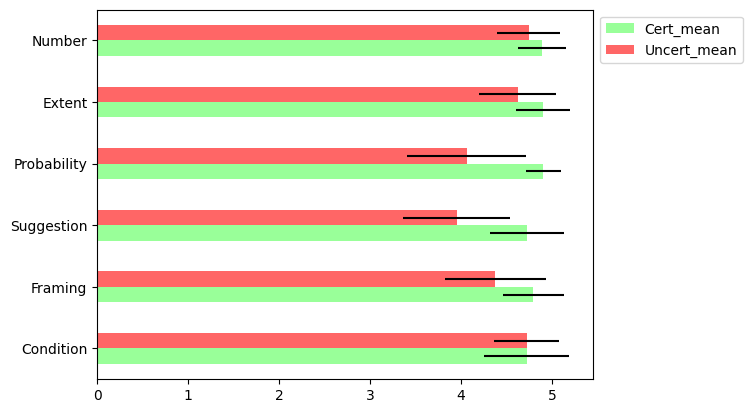

In [41]:
fig, ax = plt.subplots()
df_corr = df_corr
df_corr[["Cert_mean", "Uncert_mean"]].plot(xerr = errors, kind = "barh", ax = ax, color = ['#99ff99', '#ff6666'])
plt.legend(bbox_to_anchor = (1, 1))
plt.savefig("../results/sent-aspect-cert-corr.png", dpi = 300, bbox_inches= "tight")

## A bit of claims inspection

For the moment: pure categories. But could be reproduced with the multi-categories.

In [6]:
from collections import Counter

# load stats and vocabularies
stats_per_label = [pd.read_csv(f"analyses/stats-{label}.csv") for label in tqdm(LABELS)]
stats_new_per_label = [pd.read_csv(f"analyses/stats-{label}-new.csv") for label in tqdm(LABELS)]
vocs_per_label = [json.load(open(f"analyses/voc-{label}.json", "r")) for label in tqdm(LABELS)]

100%|██████████| 8/8 [00:00<00:00, 17.02it/s]


In [14]:
stats_concat_per_label = [pd.concat([stats_per_label[i], stats_new_per_label[i]], ignore_index = True) for i in tqdm(range(len(LABELS)))]

100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


In [127]:
stats_concat_per_label[0].head()

sentence_id  #char  #tok  ADJ  ADP  ADV  AUX  CCONJ  DET  NOUN  ...  MONEY  \
0            0    161    25    1    0    1    0      1    1     7  ...      0   
1            1    143    23    2    5    1    1      0    2     6  ...      0   
2            2    102    17    3    0    3    2      1    1     3  ...      0   
3            3    110    17    3    1    2    1      3    0     2  ...      0   
4            4     94    16    2    2    0    1      1    1     7  ...      0   

   NORP  ORDINAL  ORG  PERCENT  PERSON  PRODUCT  QUANTITY  TIME  WORK_OF_ART  
0     0        0    0        0       0        0         0     0            0  
1     0        0    0        0       0        0         0     0            0  
2     0        0    0        0       0        0         0     0            0  
3     0        0    0        0       0        0         0     0            0  
4     0        0    0        0       0        0         0     0            0  

[5 rows x 82 columns]

In [23]:
vocs_per_label = [json.load(open(f"analyses/voc-{label}-new.json", "r")) for label in tqdm(LABELS)]

100%|██████████| 8/8 [00:01<00:00,  8.00it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

context-AIC
87376
13586088


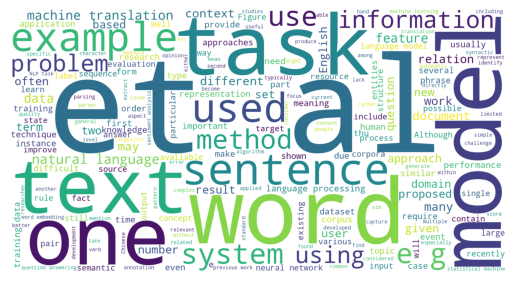

 12%|█▎        | 1/8 [00:11<01:17, 11.13s/it]

contribution-AIC
66555
10030671


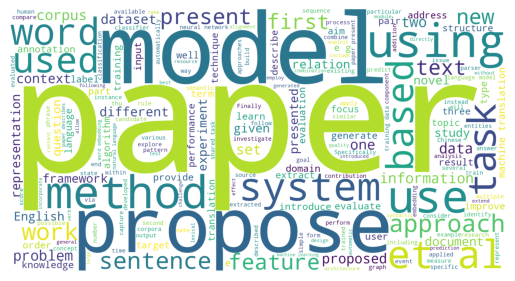

 25%|██▌       | 2/8 [00:20<01:00, 10.15s/it]

result
154868
22864558


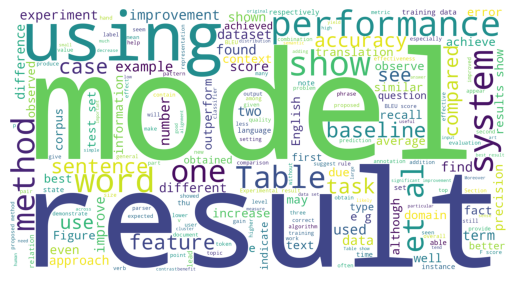

 38%|███▊      | 3/8 [00:35<01:00, 12.18s/it]

impact
2465
409292


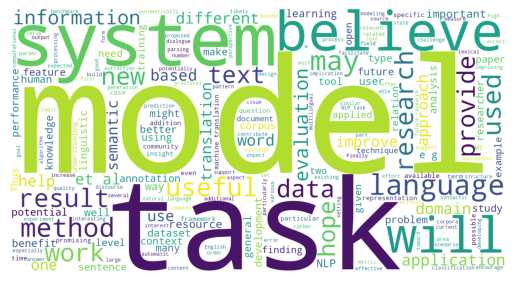

 50%|█████     | 4/8 [00:40<00:38,  9.51s/it]

directions
14867
2172531


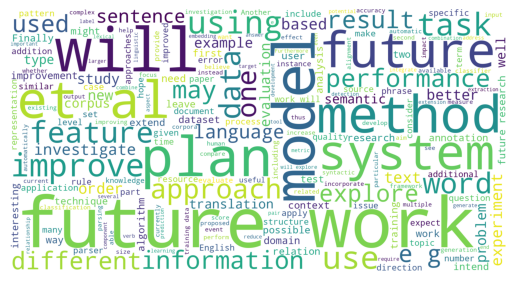

 62%|██████▎   | 5/8 [00:46<00:24,  8.16s/it]

limitation
6472
894782


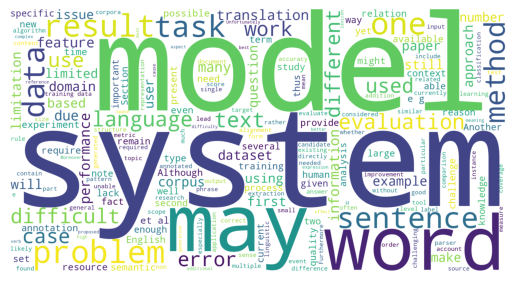

 75%|███████▌  | 6/8 [00:52<00:14,  7.35s/it]

outline-AIC
10346
986039


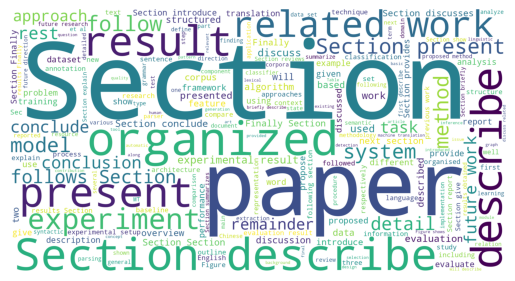

 88%|████████▊ | 7/8 [00:57<00:06,  6.62s/it]

nc
638967
83046177


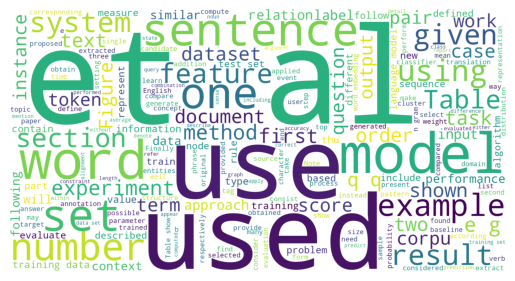

100%|██████████| 8/8 [01:43<00:00, 12.90s/it]


In [16]:
from wordcloud import WordCloud

for label in tqdm(LABELS):
    print(label)
    df_l = df.iloc[range(1000000)] # limit text quantity to 1M sentences
    df_l = df_l[df_l["unique_label"] == label]
    print(df_l.shape[0])

    mega_s = "\n".join(df_l.sentence.values.astype(str).tolist())
    print(len(mega_s))

    wc = WordCloud(collocations = True,
              background_color = "white",
              relative_scaling = 0.4,
               height = 1080,
               width = 2048,
    ).generate(mega_s)
    plt.imshow(wc)
    plt.axis("off")
    plt.savefig(f"analyses/wc-{label}.png", dpi = 200, bbox_inches = "tight")
    plt.show()


In [20]:
import string
from spacy.lang.en import stop_words
STOP_WORDS = list(spacy.lang.en.stop_words.STOP_WORDS)
STOP_WORDS.extend(string.punctuation)

8it [00:08,  1.05s/it]


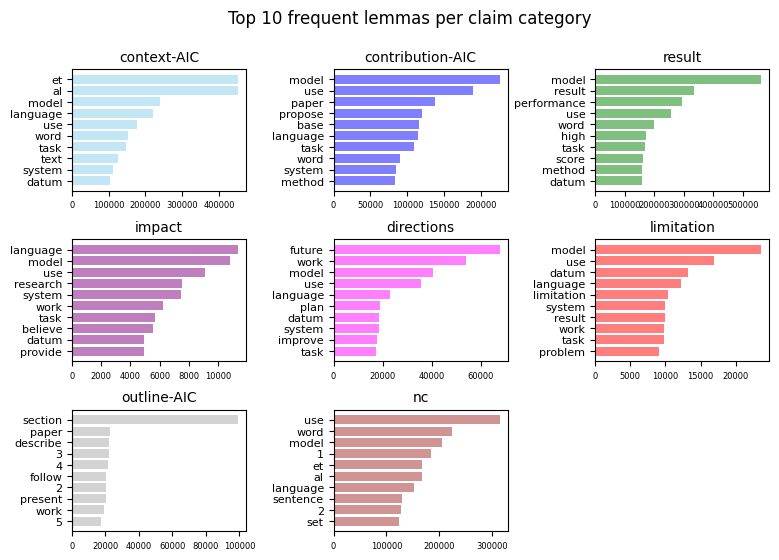

In [117]:
import matplotlib

colors = {"nc": "brown",
          "result": "green",
          "context-AIC": "skyblue",
          "contribution-AIC": "blue",
          "limitation": "red",
          "directions": "magenta",
          "outline-AIC": "darkgrey",
          "impact": "purple",
         }

matplotlib.rc('xtick', labelsize=6) 
matplotlib.rc('ytick', labelsize=8) 

fig, axes = plt.subplots(3, 3, figsize = (9, 6))
for i, label in tqdm(enumerate(LABELS)):
    ax = axes[i//3, i%3]
    inf_words = [(w, f) for (w,f) in vocs_per_label[i].items() if w not in STOP_WORDS]
    top = sorted(inf_words, key = lambda x: x[1], reverse = True)[:10]
   
    ax.barh([t[0] for t in top[::-1]], [t[1] for t in top[::-1]], color = colors[label], alpha = 0.5)
    ax.set_title(label, fontsize = 10)

axes[2, 2].set_axis_off()
plt.suptitle("Top 10 frequent lemmas per claim category", fontsize = 12)
plt.subplots_adjust(wspace = .5, hspace = 0.4)
plt.savefig(f"analyses/frquent-lemmas.png", dpi = 200, bbox_inches = "tight")
plt.show()

In [28]:
import math
POS_TAGS = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "NOUN", 
            "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
ling = []
sem = []

for i, label in tqdm(enumerate(LABELS), total = len(LABELS)):
    stats = stats_concat_per_label[i].describe()
    l = []
    s = []
    for pos in POS_TAGS:
        l.append(stats.at["mean", pos])
        s.append(stats.at["std", pos] / math.sqrt(stats.at["count", pos]))
    ling.append(l)
    sem.append(s)

ling_df = pd.DataFrame(ling, columns = POS_TAGS, index = LABELS)
sem_df = pd.DataFrame(sem, columns = POS_TAGS, index = LABELS)

100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


In [29]:
sem_df

ADJ       ADP       ADV       AUX     CCONJ       DET  \
context-AIC       0.001697  0.001629  0.000927  0.000911  0.000850  0.001431   
contribution-AIC  0.001993  0.001952  0.000920  0.000932  0.000900  0.001770   
result            0.001236  0.001322  0.000771  0.000701  0.000576  0.001148   
impact            0.008196  0.008127  0.004735  0.004889  0.003991  0.006659   
directions        0.004002  0.004014  0.002289  0.002407  0.001822  0.003417   
limitation        0.004715  0.004837  0.002890  0.003116  0.002147  0.004304   
outline-AIC       0.003786  0.004805  0.001923  0.002105  0.002270  0.004251   
nc                0.001241  0.001413  0.000679  0.000775  0.000621  0.001356   

                      NOUN       NUM      PART      PRON     PROPN     PUNCT  \
context-AIC       0.003098  0.001071  0.000611  0.000767  0.003637  0.003330   
contribution-AIC  0.003739  0.000905  0.000747  0.001019  0.002440  0.002880   
result            0.002406  0.000971  0.000431  0.000675  0.001410  0.001901   
impact            0.014120  0.002384  0.003365  0.004744  0.007439  0.009105   
directions        0.007135  0.001476  0.001822  0.002238  0.004238  0.005034   
limitation        0.008300  0.001643  0.002203  0.002922  0.003962  0.005605   
outline-AIC       0.009129  0.002681  0.001075  0.002958  0.004149  0.005556   
nc                0.007395  0.001868  0.000475  0.000717  0.002146  0.002737   

                     SCONJ       SYM      VERB         X  
context-AIC       0.000518  0.000178  0.001445  0.000409  
contribution-AIC  0.000515  0.000193  0.001805  0.000376  
result            0.000515  0.000236  0.001123  0.000227  
impact            0.002982  0.000560  0.007361  0.001045  
directions        0.001331  0.000321  0.003703  0.000659  
limitation        0.001867  0.000390  0.004300  0.000768  
outline-AIC       0.001322  0.000316  0.004240  0.000484  
nc                0.000442  0.000258  0.001208  0.000409

In [30]:
ling_df

ADJ       ADP       ADV       AUX     CCONJ       DET  \
context-AIC       2.603572  2.770171  0.957174  1.145868  0.836325  2.015109   
contribution-AIC  2.389786  2.936046  0.663501  0.664170  0.747857  2.545103   
result            2.468029  3.003192  1.161367  0.991199  0.680023  2.437831   
impact            3.027200  3.321212  1.117291  1.562378  0.927306  2.296543   
directions        2.645827  2.859134  0.987482  1.426361  0.694278  2.076431   
limitation        2.388018  2.622610  1.105654  1.450952  0.638673  2.249251   
outline-AIC       1.101377  1.995305  0.379539  0.503794  0.617224  1.746804   
nc                1.872096  2.646149  0.736400  1.071147  0.680903  2.442102   

                      NOUN       NUM      PART      PRON     PROPN     PUNCT  \
context-AIC       6.461577  0.676737  0.479699  0.663305  2.503965  4.383921   
contribution-AIC  6.880128  0.389807  0.528510  1.233711  1.411063  3.438112   
result            6.266606  0.803247  0.374054  0.973521  1.453655  3.520680   
impact            7.172124  0.155560  0.653558  1.287492  0.881508  2.881876   
directions        6.159618  0.240857  0.802173  1.177759  0.943659  2.888367   
limitation        5.759704  0.240531  0.726215  1.137202  0.711845  2.818090   
outline-AIC       4.681391  0.999680  0.120288  0.897845  0.684767  2.224812   
nc                5.848147  0.708035  0.418177  0.884359  1.902795  3.853868   

                     SCONJ       SYM      VERB         X  
context-AIC       0.338420  0.024351  2.562950  0.131570  
contribution-AIC  0.216759  0.022050  3.084420  0.082701  
result            0.680266  0.041817  2.697564  0.071765  
impact            0.527152  0.014898  3.225259  0.038590  
directions        0.345454  0.016963  3.040883  0.056425  
limitation        0.520544  0.015713  2.560912  0.052602  
outline-AIC       0.226344  0.009079  2.202671  0.018084  
nc                0.362775  0.054173  2.438715  0.164851

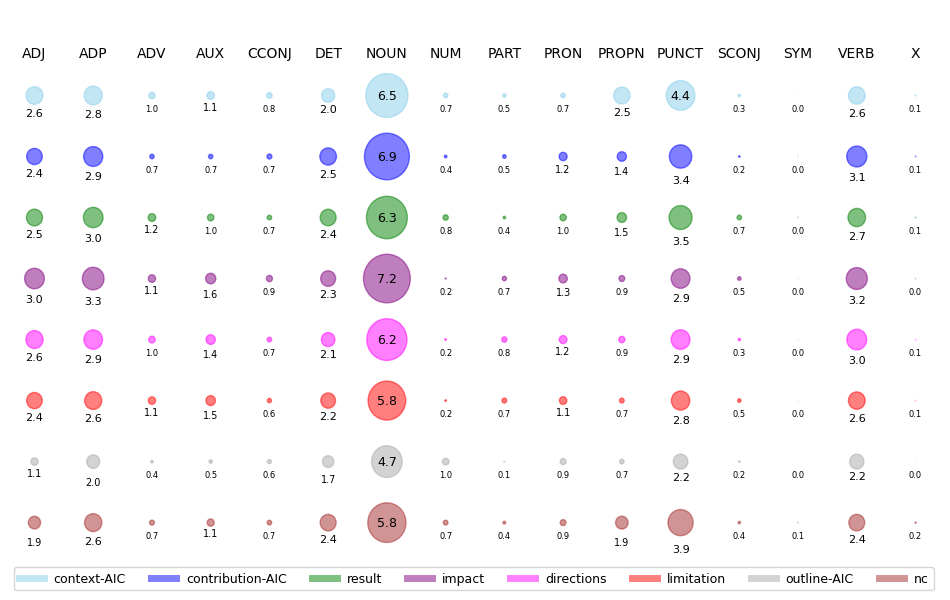

In [118]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(len(LABELS) + 1, len(POS_TAGS), figsize = (12, 7))

for j, pos in enumerate(POS_TAGS):
    ax = axes[0, j]
    ax.set_axis_off()
    ax.text(0.5, 0, pos, ha = "center", va = "bottom", fontsize = 10)

for i, label in enumerate(LABELS):
    N = 100
    # ax = axes[i+1, 0]
    # ax.set_axis_off()
    # ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center", fontsize = 8)

    for j, pos in enumerate(POS_TAGS):
        ax = axes[i + 1, j]
        ax.set_axis_off()

        val = ling_df.at[label, pos]
        radius = val / 15

        circle = plt.Circle((0.5, 0.5), radius, color = colors[label], alpha = 0.5, clip_on = False, label = label)
        ax.add_patch(circle)

        if val >=4:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 9)
        elif val >=2:
            ax.text(0.5, 0.5 - 2*radius, round(val, 1), ha = "center", va = "center", fontsize = 8)
        elif val >= 1:
            ax.text(0.5, 0.5 - 3*radius, round(val, 1), ha = "center", va = "center", fontsize = 7)
        else:
            ax.text(0.5, 0.25, round(val, 1), ha = "center", va = "center", fontsize = 6)

custom_lines = [Line2D([0], [0], color = col, lw = 5, alpha = 0.5) for col in [colors[l] for l in LABELS]]
keys = LABELS
plt.legend(custom_lines, keys, bbox_to_anchor = (1, -0.25), fontsize = 9,  ncol = 8)
plt.savefig(f"POS.png", dpi = 200, bbox_inches = "tight")
plt.show()

In [32]:
nlp = spacy.load("en_core_web_sm")
DEPS = nlp.get_pipe("parser").labels
NER = nlp.get_pipe("ner").labels

In [33]:
ner_list = []

for i, label in tqdm(enumerate(LABELS), total = len(LABELS)):
    stats = stats_concat_per_label[i].describe()
    l = []
    for ner in NER:
        l.append(stats.at["mean", ner])
    ner_list.append(l)

ner_df = pd.DataFrame(ner_list, columns = NER, index = LABELS)

100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


In [34]:
ner_df

CARDINAL      DATE     EVENT       FAC       GPE  LANGUAGE  \
context-AIC       0.287504  0.384427  0.002096  0.004386  0.276325  0.025550   
contribution-AIC  0.276389  0.087362  0.001951  0.004261  0.074298  0.031727   
result            0.456458  0.077311  0.001737  0.014255  0.071542  0.025045   
impact            0.080527  0.064877  0.001041  0.002082  0.061353  0.015410   
directions        0.121157  0.102454  0.001067  0.002564  0.076869  0.016760   
limitation        0.156052  0.051514  0.001008  0.003379  0.049713  0.019858   
outline-AIC       0.177294  0.028581  0.003925  0.003900  0.026123  0.012766   
nc                0.408502  0.151095  0.001839  0.008865  0.105889  0.022095   

                       LAW       LOC     MONEY      NORP   ORDINAL       ORG  \
context-AIC       0.003829  0.011482  0.002740  0.087001  0.033400  0.395865   
contribution-AIC  0.005487  0.007821  0.001376  0.083800  0.074105  0.395913   
result            0.017545  0.008591  0.004627  0.067754  0.045664  0.443732   
impact            0.004469  0.006456  0.000977  0.056787  0.030564  0.315702   
directions        0.007510  0.005743  0.000691  0.056638  0.037544  0.250218   
limitation        0.010292  0.004904  0.001270  0.043291  0.058796  0.217596   
outline-AIC       0.719813  0.004146  0.001852  0.041454  0.049902  0.195313   
nc                0.014721  0.008212  0.004665  0.069814  0.050074  0.335873   

                   PERCENT    PERSON   PRODUCT  QUANTITY      TIME  \
context-AIC       0.010994  0.271378  0.018105  0.001475  0.003062   
contribution-AIC  0.001446  0.099509  0.020366  0.001678  0.002129   
result            0.148724  0.115317  0.038578  0.003562  0.006894   
impact            0.001618  0.073783  0.008939  0.000304  0.001298   
directions        0.002382  0.086925  0.010990  0.000580  0.001235   
limitation        0.005972  0.060240  0.011602  0.000887  0.002600   
outline-AIC       0.000705  0.040675  0.008317  0.000533  0.000467   
nc                0.009429  0.182789  0.027099  0.003773  0.004401   

                  WORK_OF_ART  
context-AIC          0.011746  
contribution-AIC     0.008412  
result               0.006599  
impact               0.004662  
directions           0.004136  
limitation           0.004058  
outline-AIC          0.002491  
nc                   0.008483

In [268]:
stats.columns

Index(['sentence_id', '#char', '#tok', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ',
       'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
       'VERB', 'X', 'ROOT', 'acl', 'acomp', 'advcl', 'advmod', 'agent', 'amod',
       'appos', 'attr', 'aux', 'auxpass', 'case', 'cc', 'ccomp', 'compound',
       'conj', 'csubj', 'csubjpass', 'dative', 'dep', 'det', 'dobj', 'expl',
       'intj', 'mark', 'meta', 'neg', 'nmod', 'npadvmod', 'nsubj', 'nsubjpass',
       'nummod', 'oprd', 'parataxis', 'pcomp', 'pobj', 'poss', 'preconj',
       'predet', 'prep', 'prt', 'punct', 'quantmod', 'relcl', 'xcomp',
       'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC',
       'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT',
       'QUANTITY', 'TIME', 'WORK_OF_ART'],
      dtype='object')

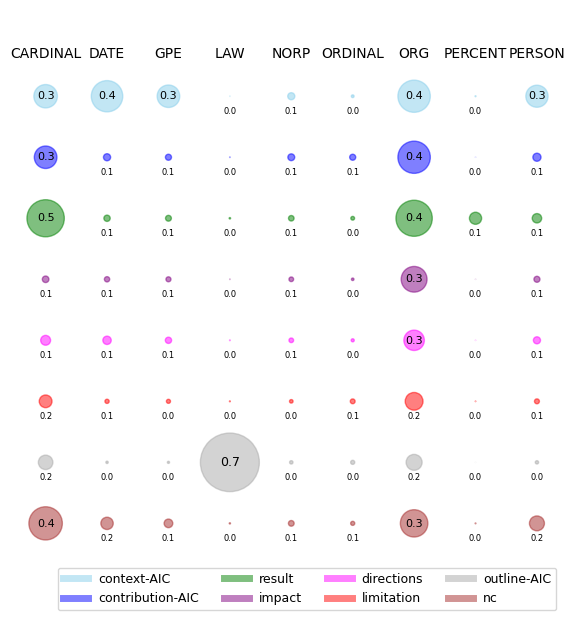

In [187]:
from matplotlib.lines import Line2D

NER = ["CARDINAL", "DATE", "GPE", "LAW", "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON"]
fig, axes = plt.subplots(len(LABELS) + 1, len(NER), figsize = (7, 7))
factor = 0.8

for j, ner in enumerate(NER):
    ax = axes[0, j]
    ax.set_axis_off()
    ax.text(0.5, 0, ner, ha = "center", va = "bottom", fontsize = 10)

for i, label in enumerate(LABELS):
    # ax = axes[i+1, 0]
    # ax.set_axis_off()
    # ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center", fontsize = 8)

    for j, ner in enumerate(NER):
        ax = axes[i + 1, j]
        ax.set_axis_off()

        val = ner_df.at[label, ner]
        radius = val * factor 

        circle = plt.Circle((0.5, 0.5), radius, color = colors[label], alpha = 0.5, clip_on = False, label = label)
        ax.add_patch(circle)
        
        if val >=0.5:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 9)
        elif val >=0.25:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 8)
        else:
            ax.text(0.5, 0.2, round(val, 1), ha = "center", va = "center", fontsize = 6)
        

custom_lines = [Line2D([0], [0], color = col, lw = 5, alpha = 0.5) for col in [colors[l] for l in LABELS]]
keys = LABELS
plt.legend(custom_lines, keys, bbox_to_anchor = (1, -0.25), fontsize = 9,  ncol = 4)
plt.savefig(f"NER.png", dpi = 200, bbox_inches = "tight")

plt.show()

In [140]:
deps_list = []
nlp = spacy.load("en_core_web_sm")
DEPS = nlp.get_pipe("parser").labels

for i, label in tqdm(enumerate(LABELS), total = len(LABELS)):
    stats = stats_concat_per_label[i].describe()
    l = []
    for dep in DEPS:
        l.append(stats.at["mean", dep])
    deps_list.append(l)

deps_df = pd.DataFrame(deps_list, columns = DEPS, index = LABELS)

deps_df

100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


ROOT       acl     acomp     advcl    advmod     agent  \
context-AIC       1.005955  0.219994  0.218961  0.308814  1.046253  0.065375   
contribution-AIC  1.005530  0.309188  0.096425  0.338965  0.754340  0.063540   
result            1.005439  0.213847  0.315983  0.411839  1.294943  0.065641   
impact            1.002275  0.260789  0.304793  0.369542  1.225899  0.047336   
directions        1.002444  0.218452  0.202543  0.359256  1.088439  0.043221   
limitation        1.003977  0.217757  0.374649  0.386681  1.197590  0.054362   
outline-AIC       1.003237  0.166323  0.022394  0.214569  0.446321  0.037725   
nc                1.016439  0.233656  0.160672  0.319669  0.839640  0.079832   

                      amod     appos      attr       aux  ...      pobj  \
context-AIC       2.530909  0.907069  0.210281  0.761854  ...  2.591514   
contribution-AIC  2.546896  0.386825  0.077632  0.654628  ...  2.708004   
result            2.251808  0.315733  0.152670  0.506851  ...  2.798749   
impact            2.832922  0.160991  0.151491  1.328197  ...  2.970557   
directions        2.574241  0.237089  0.123221  1.505936  ...  2.598475   
limitation        2.107589  0.156032  0.211899  0.946827  ...  2.411867   
outline-AIC       1.241118  0.179130  0.019403  0.224697  ...  1.886693   
nc                1.793036  0.595312  0.205541  0.601888  ...  2.495210   

                      poss   preconj    predet      prep       prt     punct  \
context-AIC       0.150592  0.021946  0.012617  2.688170  0.020432  4.438806   
contribution-AIC  0.262638  0.022892  0.011842  2.868012  0.020160  3.473604   
result            0.260670  0.030331  0.019039  2.912896  0.022571  3.565677   
impact            0.351696  0.032615  0.021529  3.220870  0.034457  2.903918   
directions        0.251418  0.018469  0.014851  2.775721  0.029858  2.914474   
limitation        0.283103  0.014464  0.017729  2.521612  0.024386  2.839427   
outline-AIC       0.283251  0.005457  0.004482  1.941323  0.017543  2.235800   
nc                0.169540  0.018944  0.017297  2.537815  0.028022  3.953499   

                  quantmod     relcl     xcomp  
context-AIC       0.019016  0.242854  0.226788  
contribution-AIC  0.010102  0.312206  0.231606  
result            0.055474  0.197735  0.159487  
impact            0.005302  0.300628  0.317127  
directions        0.007585  0.243833  0.510882  
limitation        0.013638  0.249063  0.268397  
outline-AIC       0.002958  0.126065  0.056998  
nc                0.022320  0.245855  0.180364  

[8 rows x 45 columns]

In [169]:
stds = []
for col in deps_df.columns:
    std = np.std(deps_df[col].values.tolist())
    avg = np.mean(deps_df[col].values.tolist())
    stds.append((col, std/avg))

stds = sorted(stds, key = lambda x: x[1], reverse = True)
TO_KEEP = [elt[0] for elt in stds[:12]]
print(TO_KEEP)

['quantmod', 'neg', 'nummod', 'intj', 'expl', 'appos', 'csubj', 'npadvmod', 'dep', 'parataxis', 'acomp', 'xcomp']


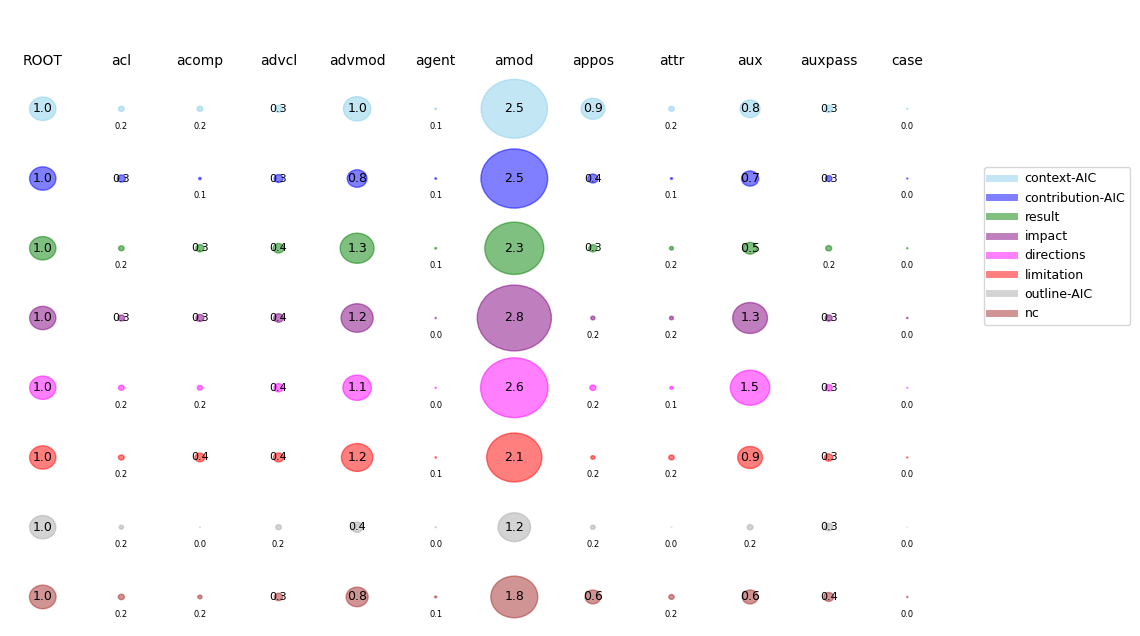

In [179]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(len(LABELS) + 1, len(TO_KEEP), figsize = (12, 8))
factor = 0.2
TO_KEEP = DEPS[:12]
for j, ner in enumerate(TO_KEEP):
    ax = axes[0, j]
    ax.set_axis_off()
    ax.text(0.5, 0, ner, ha = "center", va = "bottom", fontsize = 10)

for i, label in enumerate(LABELS):
    # ax = axes[i+1, 0]
    # ax.set_axis_off()
    # ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center", fontsize = 8)

    for j, dep in enumerate(TO_KEEP):
        ax = axes[i + 1, j]
        ax.set_axis_off()

        val = deps_df.at[label, dep]
        radius = val * factor 

        circle = plt.Circle((0.5, 0.5), radius, color = colors[label], alpha = 0.5, clip_on = False, label = label)
        ax.add_patch(circle)
        
        if val >=0.5:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 9)
        elif val >=0.25:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 8)
        else:
            ax.text(0.5, 0.2, round(val, 1), ha = "center", va = "center", fontsize = 6)
        

custom_lines = [Line2D([0], [0], color = col, lw = 5, alpha = 0.5) for col in [colors[l] for l in LABELS]]
keys = LABELS
plt.legend(custom_lines, keys, bbox_to_anchor = (4,8), fontsize = 9)
plt.show()

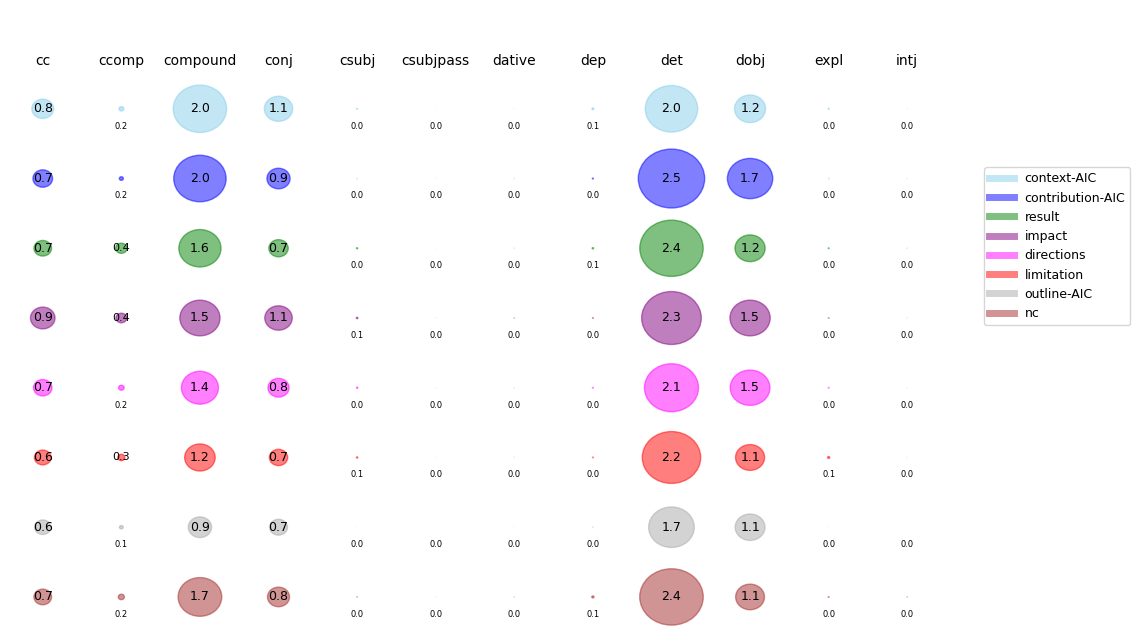

In [181]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(len(LABELS) + 1, len(TO_KEEP), figsize = (12, 8))
factor = 0.2
TO_KEEP = DEPS[12:24]
for j, ner in enumerate(TO_KEEP):
    ax = axes[0, j]
    ax.set_axis_off()
    ax.text(0.5, 0, ner, ha = "center", va = "bottom", fontsize = 10)

for i, label in enumerate(LABELS):
    # ax = axes[i+1, 0]
    # ax.set_axis_off()
    # ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center", fontsize = 8)

    for j, dep in enumerate(TO_KEEP):
        ax = axes[i + 1, j]
        ax.set_axis_off()

        val = deps_df.at[label, dep]
        radius = val * factor 

        circle = plt.Circle((0.5, 0.5), radius, color = colors[label], alpha = 0.5, clip_on = False, label = label)
        ax.add_patch(circle)
        
        if val >=0.5:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 9)
        elif val >=0.25:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 8)
        else:
            ax.text(0.5, 0.2, round(val, 1), ha = "center", va = "center", fontsize = 6)
        

custom_lines = [Line2D([0], [0], color = col, lw = 5, alpha = 0.5) for col in [colors[l] for l in LABELS]]
keys = LABELS
plt.legend(custom_lines, keys, bbox_to_anchor = (4,8), fontsize = 9)
plt.show()

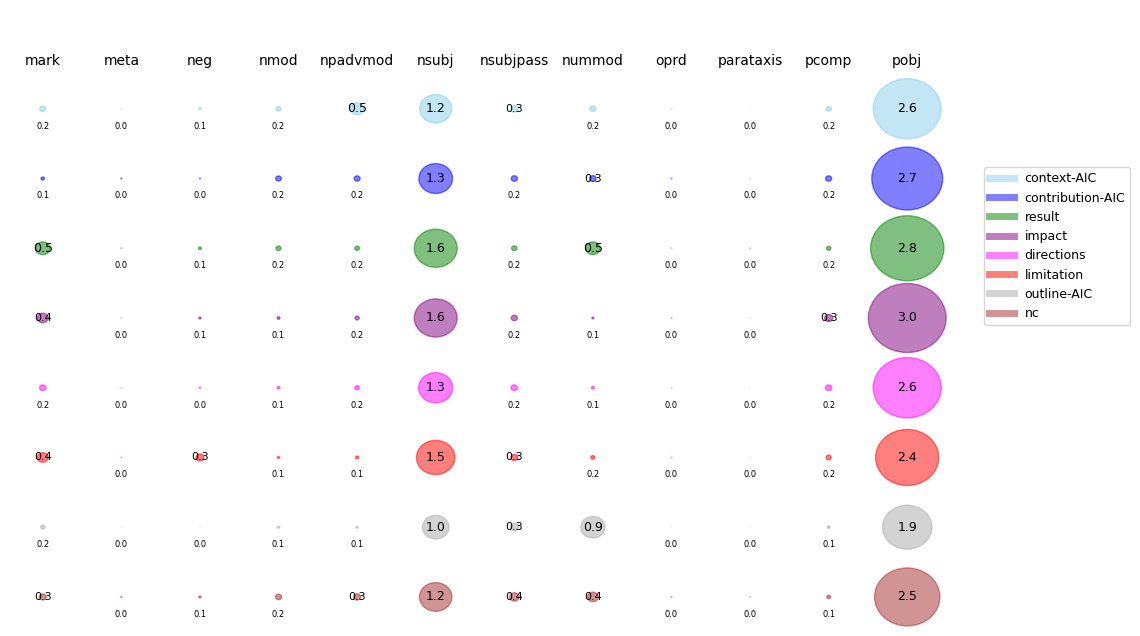

In [182]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(len(LABELS) + 1, len(TO_KEEP), figsize = (12, 8))
factor = 0.2
TO_KEEP = DEPS[24:36]
for j, ner in enumerate(TO_KEEP):
    ax = axes[0, j]
    ax.set_axis_off()
    ax.text(0.5, 0, ner, ha = "center", va = "bottom", fontsize = 10)

for i, label in enumerate(LABELS):
    # ax = axes[i+1, 0]
    # ax.set_axis_off()
    # ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center", fontsize = 8)

    for j, dep in enumerate(TO_KEEP):
        ax = axes[i + 1, j]
        ax.set_axis_off()

        val = deps_df.at[label, dep]
        radius = val * factor 

        circle = plt.Circle((0.5, 0.5), radius, color = colors[label], alpha = 0.5, clip_on = False, label = label)
        ax.add_patch(circle)
        
        if val >=0.5:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 9)
        elif val >=0.25:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 8)
        else:
            ax.text(0.5, 0.2, round(val, 1), ha = "center", va = "center", fontsize = 6)
        

custom_lines = [Line2D([0], [0], color = col, lw = 5, alpha = 0.5) for col in [colors[l] for l in LABELS]]
keys = LABELS
plt.legend(custom_lines, keys, bbox_to_anchor = (4,8), fontsize = 9)
plt.show()

In [185]:
deps_df["neg"]

context-AIC         0.085345
contribution-AIC    0.029741
result              0.113040
impact              0.081472
directions          0.044629
limitation          0.303781
outline-AIC         0.006506
nc                  0.083778
Name: neg, dtype: float64

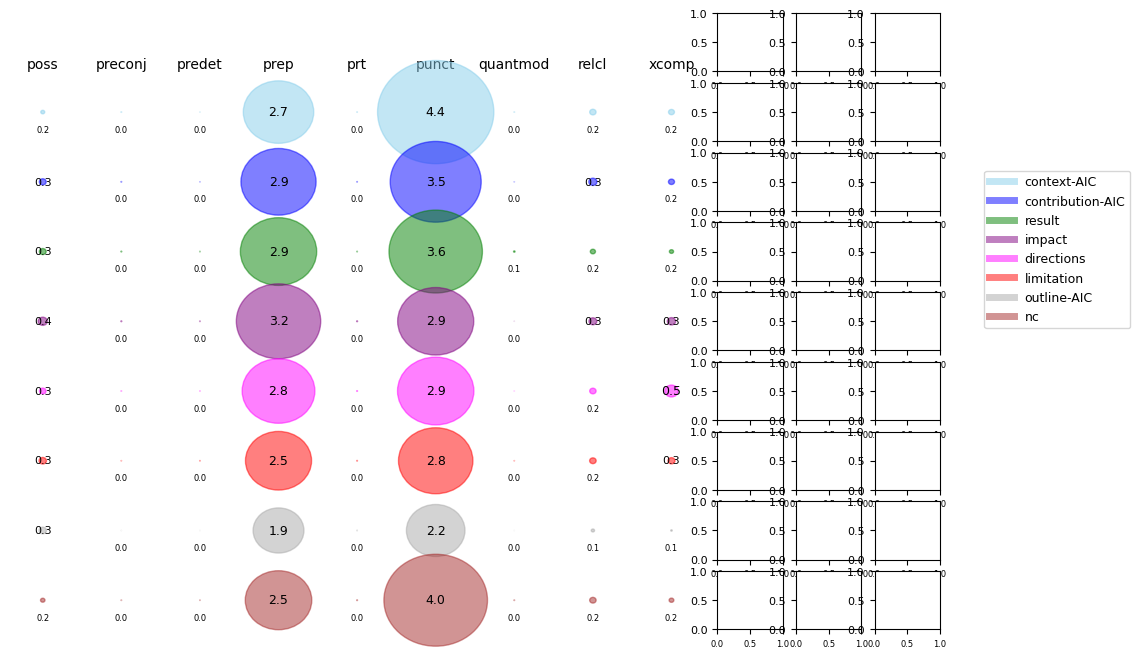

In [183]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(len(LABELS) + 1, len(TO_KEEP), figsize = (12, 8))
factor = 0.2
TO_KEEP = DEPS[36:]
for j, ner in enumerate(TO_KEEP):
    ax = axes[0, j]
    ax.set_axis_off()
    ax.text(0.5, 0, ner, ha = "center", va = "bottom", fontsize = 10)

for i, label in enumerate(LABELS):
    # ax = axes[i+1, 0]
    # ax.set_axis_off()
    # ax.text(0.5, 0.5,  label.replace("-", "\n-"), ha = "left", va = "center", fontsize = 8)

    for j, dep in enumerate(TO_KEEP):
        ax = axes[i + 1, j]
        ax.set_axis_off()

        val = deps_df.at[label, dep]
        radius = val * factor 

        circle = plt.Circle((0.5, 0.5), radius, color = colors[label], alpha = 0.5, clip_on = False, label = label)
        ax.add_patch(circle)
        
        if val >=0.5:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 9)
        elif val >=0.25:
            ax.text(0.5, 0.5, round(val, 1), ha = "center", va = "center", fontsize = 8)
        else:
            ax.text(0.5, 0.2, round(val, 1), ha = "center", va = "center", fontsize = 6)
        

custom_lines = [Line2D([0], [0], color = col, lw = 5, alpha = 0.5) for col in [colors[l] for l in LABELS]]
keys = LABELS
plt.legend(custom_lines, keys, bbox_to_anchor = (4,8), fontsize = 9)
plt.show()

In [36]:
stats_concat_per_label[1].describe()

sentence_id          #char           #tok            ADJ  \
count  9.894830e+05  989483.000000  989483.000000  989483.000000   
mean   7.638547e+06     152.559273      27.247314       2.389786   
std    4.515764e+06      72.580756      13.348498       1.982429   
min    5.000000e+00       1.000000       1.000000       0.000000   
25%    3.712483e+06     104.000000      18.000000       1.000000   
50%    7.598917e+06     141.000000      25.000000       2.000000   
75%    1.139648e+07     187.000000      33.000000       3.000000   
max    1.585080e+07    2145.000000     385.000000      42.000000   

                 ADP            ADV            AUX          CCONJ  \
count  989483.000000  989483.000000  989483.000000  989483.000000   
mean        2.936046       0.663501       0.664170       0.747857   
std         1.941786       0.915174       0.927548       0.895243   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         3.000000       0.000000       0.000000       1.000000   
75%         4.000000       1.000000       1.000000       1.000000   
max        46.000000      18.000000      27.000000      25.000000   

                 DET           NOUN  ...          MONEY           NORP  \
count  989483.000000  989483.000000  ...  989483.000000  989483.000000   
mean        2.545103       6.880128  ...       0.001376       0.083800   
std         1.760533       3.719519  ...       0.044029       0.355087   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         1.000000       4.000000  ...       0.000000       0.000000   
50%         2.000000       6.000000  ...       0.000000       0.000000   
75%         3.000000       9.000000  ...       0.000000       0.000000   
max        43.000000      99.000000  ...       7.000000      16.000000   

             ORDINAL            ORG        PERCENT         PERSON  \
count  989483.000000  989483.000000  989483.000000  989483.000000   
mean        0.074105       0.395913       0.001446       0.099509   
std         0.280917       0.734346       0.066143       0.377809   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       1.000000       0.000000       0.000000   
max         6.000000      17.000000      32.000000      15.000000   

             PRODUCT       QUANTITY           TIME    WORK_OF_ART  
count  989483.000000  989483.000000  989483.000000  989483.000000  
mean        0.020366       0.001678       0.002129       0.008412  
std         0.151623       0.043113       0.049785       0.095095  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         9.000000       5.000000       5.000000       4.000000  

[8 rows x 82 columns]

In [37]:
len_list = []

for i, label in tqdm(enumerate(LABELS), total = len(LABELS)):
    stats = stats_concat_per_label[i].describe()
    l = []
    for var in ["#char", "#tok"]:
        l.append(stats.at["mean", var])
    len_list.append(l)

len_df = pd.DataFrame(len_list, columns = ["#char", "#tok"], index = LABELS)
len_df

100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


#char       #tok
context-AIC       154.114343  28.583939
contribution-AIC  152.559273  27.247314
result            148.346611  27.649887
impact            169.138260  29.102457
directions        147.498798  26.375356
limitation        138.982258  25.008653
outline-AIC       100.124582  18.413905
nc                133.067086  26.112829

In [38]:
len_df["char2tok"] = len_df.apply(lambda x: x["#char"] / x["#tok"], axis = 1)
len_df

#char       #tok  char2tok
context-AIC       154.114343  28.583939  5.391641
contribution-AIC  152.559273  27.247314  5.599057
result            148.346611  27.649887  5.365180
impact            169.138260  29.102457  5.811821
directions        147.498798  26.375356  5.592296
limitation        138.982258  25.008653  5.557367
outline-AIC       100.124582  18.413905  5.437444
nc                133.067086  26.112829  5.095851

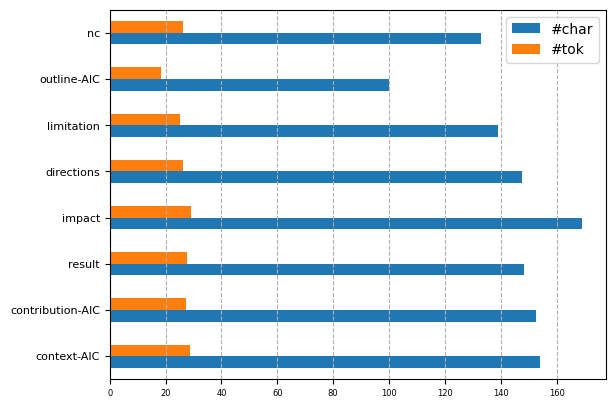

In [128]:
fig, ax = plt.subplots()
len_df[["#char", "#tok"]].plot(kind = "barh", ax = plt.gca())
ax.xaxis.grid(linestyle = "--")
plt.savefig(f"tok-chars.png", dpi = 200, bbox_inches = "tight")

In [270]:
for label in LABELS:
    print(label)
    df_sample = df.sample(1000)
    sents = df_sample[df_sample["unique_label"] == label]["sentence"].values.tolist()
    print(sents[:2])
    print()

context-AIC
['Whichever approach ends up being taken (as determined primarily by the writing system of the language in question), little attention is usually paid to pronunciation variants stemming from connected speech processes, hypoarticulation, and other phenomena typical for colloquial speech, mostly because the resource is seldom directly empirically derived.', 'Previous work typically relies on a variant of mutual nearest neighbours in the aligned embedding space of the current iteration to select likely translation candidates for the next.']

contribution-AIC
['Our architecture is a variant of the Seq2seq model where two different decoders are used instead of only one of the original architecture.', 'We presented a hypergraph sampling algorithm that overcomes the difficulties inherent in computing inside probabilities in applications where the segmentation of the tree into rules is not known. ']

result
['We can see from this chart that the relative ranking of the models remain

In [279]:
df[df["label_pred"].apply(lambda x: set(x) == set(["outline-AIC", "contribution-AIC"]))][["sentence", "section"]].values.tolist()[:2]

[['This model is described in section 2. Translation results from the four source languages made available for the shared task (es: Spanish, fr: French, de: German, and fi: Finnish) into English (en) are presented and discussed. ',
  'Introduction'],
 ['To do this, we used a fairly standard configuration for phrase-based SMT, described in the next section. ',
  'Introduction']]

In [273]:
df[(df["paper_id"] == 30501) & (df["section"] == "Conclusion and Future Work")]["sentence"].values.tolist()

['In this work, we found that none of the most common part-of-speech tagging metrics bear a strong relationship to good grammar induction performance.',
 'Although our experiments only involve English, the poor correspondence we find between the various tagging metrics and grammar induction performance raises concerns about their relationship more broadly.',
 'We additionally found that while tagging accuracy measures do correlate with better supervised parsing, common information theoretic ones do not strongly predict better performance on either task.',
 'Furthermore, the supervised experiments indicate that informative part-of-speech tags are important for good parsing. ',
 'The next step is to explore better tagging metrics that correspond more strongly to better grammar induction performance.',
 'A good metric should use all the information we have, including the gold trees, to evaluate.',
 'Finally, we should explore grammar induction schemes that do not rely on prior parts-of-sp

In [283]:
df_papers[df_papers["authors"].apply(lambda x: "Gardent" in str(x))]

paper_id              id source  \
507          507        P07-1042    ACL   
514          514        W05-1605    ACL   
518          518        W03-2410    ACL   
10930      10930        C10-2006    ACL   
13014      13014        W12-1602    ACL   
...          ...             ...    ...   
82128      82128      2204.05879  arXiv   
82831      82831      2207.03145  arXiv   
87701      87701      2308.15298  arXiv   
103612    103612      2310.03878  arXiv   
104430    104430  cmp-lg/9609001  arXiv   

                                                    title  \
507     A Symbolic Approach to Near-Deterministic Surf...   
514      Generating and Selecting Grammatical Paraphrases   
518     Which bridges for bridging definite descriptions?   
10930   Benchmarking for syntax-based sentential infer...   
13014   An End-to-End Evaluation of Two Situated Dialo...   
...                                                   ...   
82128   Generating Full Length Wikipedia Biographies: ...   
82831   Active Learning and Multi-label Classification...   
87701   KGConv, a Conversational Corpus grounded in Wi...   
103612  Automatic and Human-AI Interactive Text Genera...   
104430           Corrections and Higher-Order Unification   

                                                  authors  year  \
507              [['Gardent', 'Claire'], ['Kow', 'Eric']]  2007   
514              [['Gardent', 'Claire'], ['Kow', 'Eric']]  2005   
518     [['Gardent', 'Claire'], ["Manu{\\'e}lian", "H{...  2003   
10930       [['Bedaride', 'Paul'], ['Gardent', 'Claire']]  2010   
13014   [['Rojas-Barahona', 'Lina M.'], ['Lorenzo', 'A...  2012   
...                                                   ...   ...   
82128          [['Fan', 'Angela'], ['Gardent', 'Claire']]  2022   
82831   [['Brabant', 'Quentin'], ['Rojas-Barahona', 'L...  2022   
87701   [['Brabant', 'Quentin'], ['Lecorve', 'Gwenole'...  2023   
103612  [['Dou', 'Yao'], ['Laban', 'Philippe'], ['Gard...  2023   
104430  [['Gardent', 'Claire'], ['Kohlhase', 'Michael'...  1996   

                                        publisher             category  \
507     Association for Computational Linguistics           Generation   
514     Association for Computational Linguistics                  NaN   
518                                           NaN                  NaN   
10930            Coling 2010 Organizing Committee                  NaN   
13014   Association for Computational Linguistics                  NaN   
...                                           ...                  ...   
82128                                         NaN            ['cs.CL']   
82831                                         NaN            ['cs.CL']   
87701                                         NaN   ['cs.CL', 'cs.AI']   
103612                                        NaN            ['cs.CL']   
104430                                        NaN  ['cmp-lg', 'cs.CL']   

        num_cited_by                     xml_path  ...  nb_pred_claims  \
507             30.0             P07-1042.tei.xml  ...              59   
514             31.0             W05-1605.tei.xml  ...              41   
518             34.0             W03-2410.tei.xml  ...              56   
10930            1.0             C10-2006.tei.xml  ...              82   
13014            7.0             W12-1602.tei.xml  ...              65   
...              ...                          ...  ...             ...   
82128            NaN  2204.05879v1.grobid.tei.xml  ...              98   
82831            NaN  2207.03145v1.grobid.tei.xml  ...              39   
87701            NaN  2308.15298v1.grobid.tei.xml  ...              55   
103612           NaN  2310.03878v1.grobid.tei.xml  ...              42   
104430           NaN     9609001v1.grobid.tei.xml  ...              34   

        #context-AIC #contribution-AIC  #result  #impact  #directions  \
507               18                10       20        0            3   
514               10         

In [299]:
s = "In Section 2, we provide an overview of related works"

doc = nlp(s)
for e in doc.ents:
    print(e, e.label_)

Section 2 LAW


## Sequences

In [348]:
df.head(1)

sentence_id  paper_id  sent_id_in_paper  \
0            0         0                 0   

                                            sentence   section  -2  -1  \
0  There is a need to measure word similarity whe...  abstract  -1  -1   

   candidate  sentence_certainty  \
0       True            4.546492   

                                    aspect_certainty label_anno  \
0  [[Condition, Certain], [Suggestion, Certain], ...         []   

      label_pred  rel_pos_in_paper unique_label  Number  Extent Probability  \
0  [context-AIC]          0.005291        mixed  absent  absent      absent   

  Condition  Framing Suggestion  
0   Certain  Certain    Certain

In [ ]:
sequences = []

last_paper = -1
last_section = -1
last_labels = []
last_seq = {}

for i, row in df.iterrows():
    paper = row["paper_id"]
    section = row["section"]
    labels = row["label_pred"]

## Core claims

Core claims should:  
- be in the same article
- in different sections
- have overlapping categories
- have a high similarity --> talk about the same things, but in different ways ...